## Memory encoding and reinstatement in the developing brain  
This notebook runs the analyses and visualizations for the paper. 

1. [Participants](#participants)
2. [Behavioral analyses](#behavior)
3. [Memory encoding GLM analyses](#glm)
4. [Memory reinstatement MVPA analyses](#mvpa)
5. [Group differences in HPC and mPFC](#rois)
6. [Control analysis: motion](#motion)
7. [Control analysis: task activation](#task)

In [2]:
# Import a few things 
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import nibabel as nib
from nibabel.processing import conform
from nilearn import plotting

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%autosave 5

Autosaving every 5 seconds


In [2]:
# Set some paths 
# Get the base directory
curr_dir = os.getcwd()
os.chdir('../') # Move into the root folder 
base_dir = os.getcwd()
os.chdir(curr_dir) # Come back

fmriprep_path = '%s/data/fmriprep_memory/' % base_dir
fsl_feat_path = '%s/data/memory_feat_folders/' % base_dir
timing_path = '%s/data/Ginsburg_Timing_Info/' % base_dir
randomise_path='%s/data/randomise' % base_dir

# what is the main color palette?
colors = sns.color_palette('cubehelix',2)

# separate palettes for comp and pi
comp_palette = sns.color_palette('light:#2b6f39_r',3)  
pi_palette = sns.color_palette('light:#d490c6_r',3) 

# what colors for looking at the effect of spontaneous remembering during rest?  
spont_mem_colors = ['#3F403F','#FF934F']

# separate palettes for no spontaneous memory and spontaneous memory
nothought_palette = sns.color_palette('light:#3F403F',3)[1:]
thought_palette = sns.color_palette('light:#FF934F',3)[1:]

# set some whole brain plotting criteria (use the value used in TFCE correction for thresholding)
thresh=2.41
vmax=6
cut_coords=(4,-20,-10)

In [3]:
# Functions
def plot_whole_brain_results(group,analysis_type,contrast,randomise_type,tstat_type):
    ''' Takes the following inputs:
    group = group being examined ('comp' 'pi' 'all')
    analysis type = the first level analysis type ('Imm_Detail' 'Imm_Recognition' 'FaceObject')
    zstat = the zstat at first level (e.g., 'zstat3')
    randomise_type = the type of randomise analysis that was run ('default' 'group' 'group_mem')
    tstat_type = the type of tstat you want to look at from the randomise output ('tstat1' 'cluster_manual_tstat1')
    '''

    # get the contrast name if it is a zstatistic (when the analysis type is not multivariate)
    if 'zstat' in contrast:
        # first, get the names of the zstat contrasts possible for this analysis, using one subject as an example
        contrast_file=np.loadtxt('%s/sub-%s/Memory_%s.feat/design.con' %(fsl_feat_path,'002',analysis_type),
                   str,delimiter='\n')
        contrasts=[line.split('\t')[1] for line in contrast_file if 'ContrastName' in line]

        # transform to the contrast name 
        contrast_name=contrasts[int(contrast.split('zstat')[1])-1] 
    else:
        contrast_name=contrast
    
    # then get the name of the tstat contrasts possible for the group analysis 
    # if default, then you did a sign test
    if randomise_type=='default':
        group_contrasts=['positive_effect','negative_effect']
    
    # otherwise, load the group contrasts
    # do it differently if memory was a covariate, since that could be named differently
    elif randomise_type=='group':
        group_contrast_file=glob.glob('%s/randomise_group_files/%s_%s_group.con' %(base_dir,group,analysis_type))[0]
        group_contrasts=np.loadtxt(group_contrast_file, str,delimiter='\n')
        group_contrasts=[line.split('\t')[1] for line in group_contrasts if 'ContrastName' in line] 

    elif randomise_type=='group_mem':
       # load the group contrasts 
        group_contrast_file=glob.glob('%s/randomise_group_files/%s_%s_*group*mem*.con' %(base_dir,group,analysis_type))[0]
        group_contrasts=np.loadtxt(group_contrast_file, str,delimiter='\n')
        group_contrasts=[line.split('\t')[1] for line in group_contrasts if 'ContrastName' in line] 
    elif randomise_type == 'age':    
        group_contrast_file=glob.glob('%s/randomise_group_files/%s_%s_age.con' %(base_dir,group,analysis_type))[0]
        group_contrasts=np.loadtxt(group_contrast_file, str,delimiter='\n')
        group_contrasts=[line.split('\t')[1] for line in group_contrasts if 'ContrastName' in line] 
    
    # finally, get the group contrast name
    group_contrast_name=group_contrasts[int(tstat_type.split('tstat')[1])-1]   

    # change the plotting colors if the contrast is negative 
    if 'negative' in group_contrast_name:
        cmap='cold_hot_r'
    else:
        cmap='cold_hot'

    # load the tstat image (named differently depending on if it was a sign test or not)
    if randomise_type=='default':
        tstat_nii='%s/%s/%s_%s_%s.nii.gz' %(randomise_path,analysis_type,group,contrast,tstat_type)
    else:
        tstat_nii='%s/%s/%s_%s_%s_%s.nii.gz' %(randomise_path,analysis_type,group,randomise_type,contrast,tstat_type)

    # if it is a randomise output, print the clusters that were significant
    if 'cluster_manual' in tstat_type:
        if randomise_type=='default':
            tfce_clusters=pd.read_csv('%s/%s/%s_%s_%s.txt' %(randomise_path,analysis_type,group,contrast,tstat_type),delimiter='\t')
        else:
            tfce_clusters=pd.read_csv('%s/%s/%s_%s_%s_%s.txt' %(randomise_path,analysis_type,group,randomise_type,contrast,tstat_type),delimiter='\t')

        print(tfce_clusters)
        
    # plot it! 
    fig = plotting.plot_stat_map(tstat_nii,title='%s\n %s - %s' %(contrast_name,group,group_contrast_name),
                                 cut_coords=cut_coords,vmax=vmax,
                           threshold=thresh,cmap=cmap,draw_cross=False)

    # save the figure 
    fig.savefig('../plots/%s_%s_%s_%s.svg' %(analysis_type,group,contrast,tstat_type))
    
    
    # plot all possible slices, for greater transparency 
    for slice_type in ['x','y','z']:
        slices=plotting.plot_stat_map(tstat_nii,
                                      title='%s\n %s - %s' %(contrast_name,group,group_contrast_name),
                                       threshold=thresh,cmap=cmap,
                                display_mode=slice_type,vmax=vmax,
                           cut_coords=range(-51, 51, 10),)
        # save the figure 
        slices.savefig('../plots/%s_%s_%s_%s_%s_slices.svg' %(analysis_type,group,contrast,tstat_type,slice_type))
    
    # return the t-statistic
    return tstat_nii
 

## Participants <a id='participants'></a>

In [4]:
# load the data csv file 
data_df=pd.read_csv('%s/data/memory_fmri_data.csv' %base_dir,index_col=0)
data_df.head()

sub_ids  pi_status   ages  genders train_version  hit_rates_imm  \
0  sub-002        0.0   9.98      0.0      Version2           0.60   
1  sub-003        0.0  11.55      1.0      Version2           0.75   
2  sub-004        0.0  14.34      1.0      Version2           0.80   
3  sub-005        0.0  17.61      0.0      Version1           0.55   
4  sub-006        1.0   5.53      1.0      Version1           0.30   

   false_alarms_imm  dprime_vals_imm  partial_memory_imm  detailed_assoc_imm  \
0              0.40             0.20                0.15                0.50   
1              0.60             0.15                0.15                0.30   
2              0.55             0.25                0.35                0.35   
3              0.15             0.40                0.15                0.65   
4              0.35            -0.05                0.15                0.15   

   debrief_endorse_memory  avg_fd_memory_run-1  prop_outliers_memory_run-1  \
0                     NaN             0.339161                    0.057971   
1                     NaN             0.134125                    0.028986   
2                     1.0             0.101249                    0.000000   
3                     1.0             0.037135                    0.000000   
4                     NaN             0.257179                    0.054726   

   avg_fd_rest_run-1  prop_outliers_rest_run-1  avg_fd_rest_run-2  \
0           0.141514                  0.000000           0.135468   
1           0.104019                  0.000000           0.136754   
2           0.136565                  0.006667           0.208841   
3           0.040017                  0.000000           0.050310   
4           0.107376                  0.000000           0.134871   

   prop_outliers_rest_run-2  included_encoding  included_reinstatement  
0                  0.006667                1.0                     1.0  
1                  0.000000                1.0                     1.0  
2                  0.040000                1.0                     1.0  
3                  0.000000                1.0                     1.0  
4                  0.006667                1.0                     1.0

In [5]:
# summarize the participant demographics
# Note: comp is shorthand for "comparison" = typically developmental histories
# pi is shorthand for "previously institutionalized" = history of early adversity 
for i, group in enumerate(['comp','pi']):
    ages=data_df[data_df.pi_status==i].ages
    genders=data_df[data_df.pi_status==i].genders
    usable_encoding = data_df[data_df.pi_status==i].included_encoding
    usable_reinstatement = data_df[data_df.pi_status==i].included_reinstatement
    
    print('%s: N = %d (%d female); M age = %0.2f years, range = %0.2f - %0.2f'% (
    group, len(ages),sum(genders==0),np.mean(ages),np.min(ages),np.max(ages)))
    
    print('usable for encoding: N = %d; usable for reinstatement: N = %d' %(sum(usable_encoding),
                                                                            sum(usable_reinstatement)))
    print()

comp: N = 49 (26 female); M age = 11.68 years, range = 6.65 - 17.61
usable for encoding: N = 46; usable for reinstatement: N = 42

pi: N = 32 (22 female); M age = 12.86 years, range = 5.53 - 17.63
usable for encoding: N = 29; usable for reinstatement: N = 25



## Behavioral analyses <a id='behavior'></a>
Examine behavioral memory performance in comparison and youth with a history of early adversity.

detailed_assoc_imm in comp (N = 49): M = 0.4061, SD = 0.1713
t-test: t = 11.369, pval = 0.000, cohen's d = 1.641
correlation with age: rval = -0.056, pval = 0.701


detailed_assoc_imm in pi (N = 32): M = 0.3641, SD = 0.1733
t-test: t = 7.680, pval = 0.000, cohen's d = 1.379
correlation with age: rval = 0.431, pval = 0.014




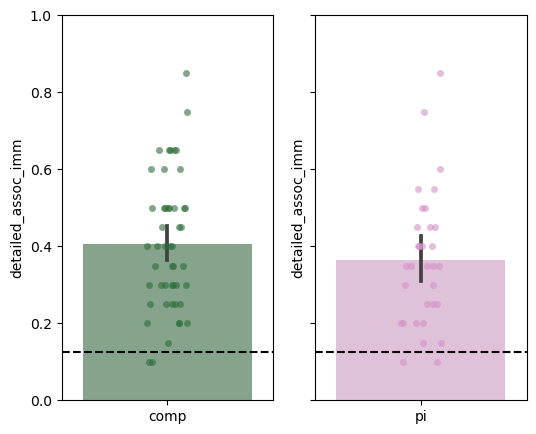

In [6]:
# First, plot the memory performance of the two different groups 

depend_var='detailed_assoc_imm' # this is the column name for item-location-context memory ('holistic' recall)
chance=0.125 # chance is 12.5% on average

# preset the figure  
fig,ax = plt.subplots(1,2,figsize=(6,5),sharey=True)

# cycle through groups 
for i, group in enumerate(['comp','pi']):

    # get just their data
    acc_df = data_df[data_df.pi_status==i]

    # Plot it 
    np.random.seed(0)

    sns.barplot(y=depend_var,data=acc_df,alpha=0.6,color=colors[i],ax=ax[i])
    sns.stripplot(y=depend_var,data=acc_df,alpha=0.6,color=colors[i],ax=ax[i])
    ax[i].set_xticks([0],[group])
    ax[i].set_ylim(0,1)
    ax[i].axhline(chance,linestyle='dashed',color='k')

    # calculate the effect size and statistics
    print('%s in %s (N = %d): M = %0.4f, SD = %0.4f' %(depend_var,group,len(acc_df[depend_var]),
                                                      np.mean(acc_df[depend_var]),np.std(acc_df[depend_var])))
    cohens_d=(np.mean(acc_df[depend_var]) - chance)/(np.std(acc_df[depend_var]))
    
    tval,pval=stats.ttest_1samp(acc_df[depend_var],chance)
    print("t-test: t = %0.3f, pval = %0.3f, cohen's d = %0.3f" % (tval,pval,cohens_d))
    
    rval,pval=stats.pearsonr(acc_df['ages'],acc_df[depend_var])
    print("correlation with age: rval = %0.3f, pval = %0.3f" %(rval,pval))

    print()
    print()
    fig.savefig('../plots/%s_behav_%s.svg' %(depend_var,group))

In [7]:
# Now test for any group differences and interactions
# set up the ANOVA
interX_lm = ols("detailed_assoc_imm  ~ ages + C(pi_status) + ages * C(pi_status)", data_df).fit()
anova_model = sm.stats.anova_lm(interX_lm, typ=3) 

ss_factors = anova_model['sum_sq'][:-1]  # Exclude the residual
ss_error = anova_model['sum_sq'][-1]     # Residual sum of squares

# Calculate partial eta squared for each factor
partial_eta_squared = ss_factors / (ss_factors + ss_error)

# Print partial eta squared as part of the anova
anova_model['part_eta_sq'] = partial_eta_squared
print(anova_model)

                     sum_sq    df          F    PR(>F)  part_eta_sq
Intercept          0.620635   1.0  21.561722  0.000014     0.218764
C(pi_status)       0.161467   1.0   5.609589  0.020371     0.067905
ages               0.004549   1.0   0.158034  0.692073     0.002048
ages:C(pi_status)  0.126254   1.0   4.386221  0.039520     0.053894
Residual           2.216377  77.0        NaN       NaN          NaN


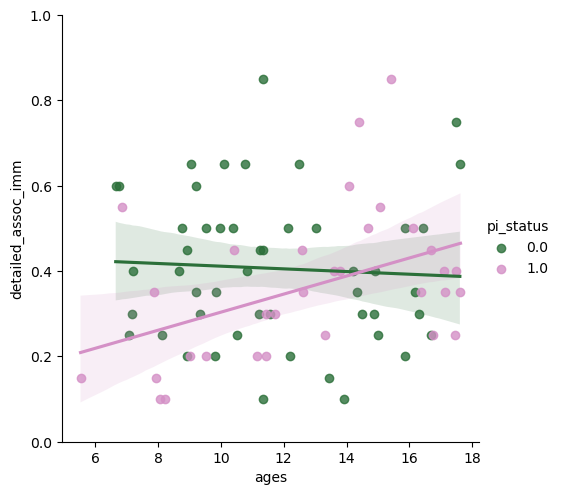

In [8]:
# Plot the age by group interaction 
fig = sns.lmplot(x='ages',y=depend_var,data=data_df,hue='pi_status',palette='cubehelix')
plt.ylim(0,1)
fig.savefig('../plots/%s_behav_by_age_adv.svg' %(depend_var))

Let's look more closely at memory behavior --- specifically, holistic episodic memory (item-location-context memory) versus partial memory (only for item-context, but not location)

comp
Corr with age -- Holistic: (-0.056240241694387266, 0.7011098408156143)
Corr with age -- Partial: (-0.2224132912142506, 0.12453542690869293)
Corr with age -- No mem: (0.18670876505636497, 0.19894888834999402)
pi
Corr with age -- Holistic: (0.4308317181697381, 0.013830435138322224)
Corr with age -- Partial: (-0.01179755669395155, 0.9489033662027531)
Corr with age -- No mem: (-0.4483407711118905, 0.01006685794270136)


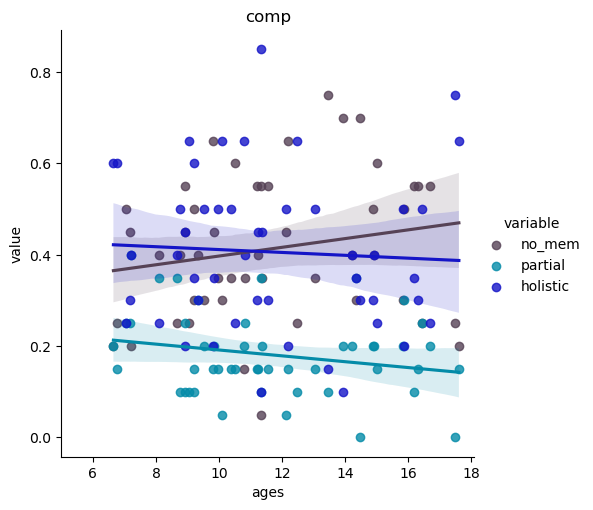

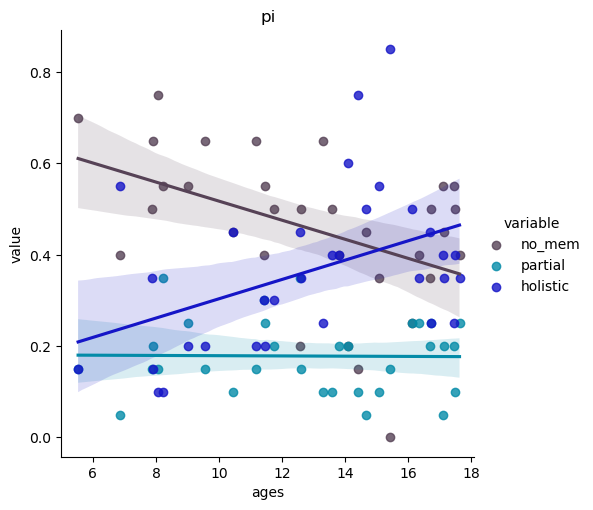

In [9]:
# Could a difference in groups be due to PI kids showing more partial memory, or just having more no memory trials? 
# Let's visualize and examine relationships between group, age, and partial memory 
for i, group in enumerate(['comp','pi']):
    
    # make a smaller dataframe for plotting
    acc_df_all= pd.DataFrame({'holistic':data_df['detailed_assoc_imm'],
                          'partial':data_df['partial_memory_imm'],
                          'no_mem':1 - (data_df['partial_memory_imm']+data_df['detailed_assoc_imm']),
                          'ages':data_df['ages'],
                         'pi_status':data_df['pi_status']})

    acc_df_all = acc_df_all[acc_df_all.pi_status==i]
    acc_df = acc_df_all.melt(value_vars=['no_mem','partial','holistic'],id_vars=['pi_status','ages'])
      
    ## by age 
    np.random.seed(0) # random seed for confidence intervals
    fig = sns.lmplot(x='ages',y='value',data=acc_df,hue='variable',palette=[sns.color_palette('dark:#564256',2)[1],
 sns.color_palette('dark:#048BA8',2)[1],
 sns.color_palette('dark:#1515C7',2)[1]])
    
    plt.title(group)
    plt.xlim(5,18.1)
    print(group)
    print('Corr with age -- Holistic:',stats.pearsonr(acc_df_all['ages'],acc_df_all['holistic']))
    print('Corr with age -- Partial:',stats.pearsonr(acc_df_all['ages'],acc_df_all['partial']))
    print('Corr with age -- No mem:',stats.pearsonr(acc_df_all['ages'],acc_df_all['no_mem']))
    
    fig.savefig('../plots/%s_behav_holistic_partial_age.svg' %(group))

Another important behavioral measure to explore is whether there were differences in memory behavior based on whether children endorsed spontaneously recalling a memory during the rest period or not? 

detailed_assoc_imm in no_spont_mem (N = 38): M = 0.3645, SD = 0.1642
t-test: t = 8.871, pval = 0.000, cohen's d = 1.458
correlation with age: rval = 0.326, pval = 0.045


detailed_assoc_imm in spont_mem (N = 25): M = 0.4420, SD = 0.1665
t-test: t = 9.325, pval = 0.000, cohen's d = 1.903
correlation with age: rval = 0.065, pval = 0.756




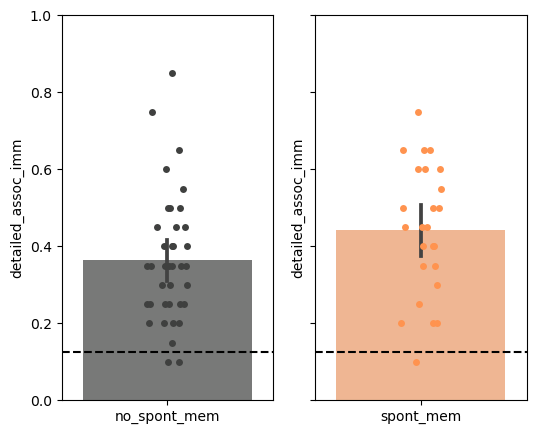

In [10]:

# preset figure
fig,ax = plt.subplots(1,2,figsize=(6,5),sharey=True)

# cycle through groups 
for i, group in enumerate(['no_spont_mem','spont_mem']):

    # get just their data
    acc_df = data_df[data_df.debrief_endorse_memory==i]

    # Plot it 
    np.random.seed(0)
    
    sns.barplot(y=depend_var,data=acc_df,alpha=0.7,color=spont_mem_colors[i],ax=ax[i])
    sns.stripplot(y=depend_var,data=acc_df,alpha=1,color=spont_mem_colors[i],ax=ax[i])
    ax[i].set_xticks([0],[group])
    ax[i].set_ylim(0,1)
    ax[i].axhline(chance,linestyle='dashed',color='k')

    # calculate the effect size and statistics
    print('%s in %s (N = %d): M = %0.4f, SD = %0.4f' %(depend_var,group,len(acc_df[depend_var]),
                                                      np.mean(acc_df[depend_var]),np.std(acc_df[depend_var])))
    cohens_d=(np.mean(acc_df[depend_var]) - chance)/(np.std(acc_df[depend_var]))
    
    tval,pval=stats.ttest_1samp(acc_df[depend_var],chance)
    print("t-test: t = %0.3f, pval = %0.3f, cohen's d = %0.3f" % (tval,pval,cohens_d))
    
    rval,pval=stats.pearsonr(acc_df['ages'],acc_df[depend_var])
    print("correlation with age: rval = %0.3f, pval = %0.3f" %(rval,pval))

    print()
    print()
    fig.savefig('../plots/%s_behav_%s.svg' %(depend_var,group))

In [11]:
# Now test for any group differences and interactions
# set up the ANOVA
interX_lm = ols("detailed_assoc_imm  ~ C(debrief_endorse_memory) + ages", data_df).fit()
anova_model = sm.stats.anova_lm(interX_lm, typ=3) 

ss_factors = anova_model['sum_sq'][:-1]  # Exclude the residual
ss_error = anova_model['sum_sq'][-1]     # Residual sum of squares

# Calculate partial eta squared for each factor
partial_eta_squared = ss_factors / (ss_factors + ss_error)

# Print partial eta squared as part of the anova
anova_model['part_eta_sq'] = partial_eta_squared
print(anova_model)

# Follow up T-test to check for differences between the two groups 
print('\nFollow up t-test for group differences:')
print(stats.ttest_ind(data_df['detailed_assoc_imm'][data_df['debrief_endorse_memory']==0],
               data_df['detailed_assoc_imm'][data_df['debrief_endorse_memory']==1]))

                             sum_sq    df         F    PR(>F)  part_eta_sq
Intercept                  0.150806   1.0  5.535588  0.021930     0.084467
C(debrief_endorse_memory)  0.133123   1.0  4.886487  0.030892     0.075308
ages                       0.083357   1.0  3.059735  0.085368     0.048521
Residual                   1.634583  60.0       NaN       NaN          NaN

Follow up t-test for group differences:
Ttest_indResult(statistic=-1.7939141766212865, pvalue=0.07778321800176706)


## Memory encoding GLM analyses <a id='glm'></a>
What is happening in the brain during the initial encoding of item-location-context associations that children will remember?

In [12]:
analysis_type='Imm_Detail' # name of the GLM analysis (immediate detailed memory)

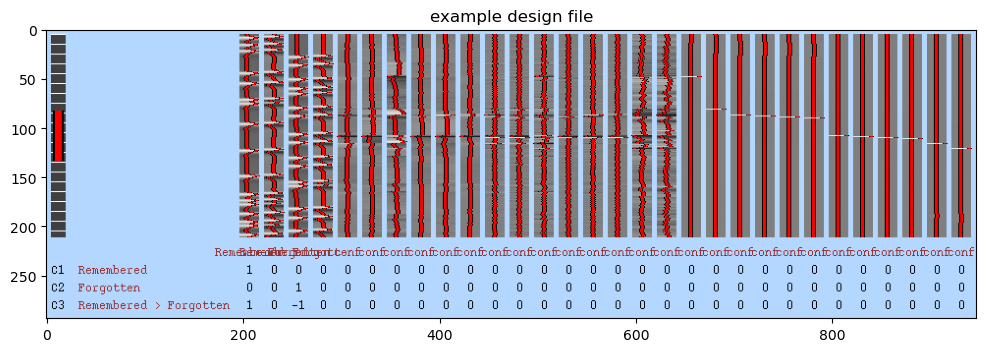

In [13]:
# View a single example subject design file
ppt='002'

# load the design file
design_img=plt.imread('%s/sub-%s/Memory_%s.feat/design.png' %(fsl_feat_path,ppt,analysis_type))
plt.figure(figsize=(12,18))
plt.title('example design file')
plt.imshow(design_img)

   Cluster Index  Voxels         P  -log10(P)   MAX  MAX X (mm)  MAX Y (mm)  \
0              5    1052  0.000086       4.06  4.77         -50         -70   
1              4     787  0.000925       3.03  4.61          26         -14   
2              3     566  0.008260       2.08  4.04         -64         -34   
3              2     548  0.009980       2.00  4.40         -40           6   
4              1     467  0.024000       1.62  4.71          54         -28   

   MAX Z (mm)  COG X (mm)  COG Y (mm)  COG Z (mm)  
0          -8       -53.0      -56.90       -8.57  
1         -20        42.1      -38.10      -13.30  
2          36       -55.4      -32.20       42.10  
3          24       -45.0        6.11       32.00  
4          50        49.8      -33.90       51.50  


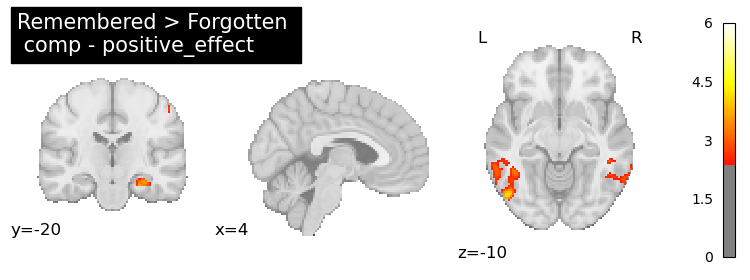

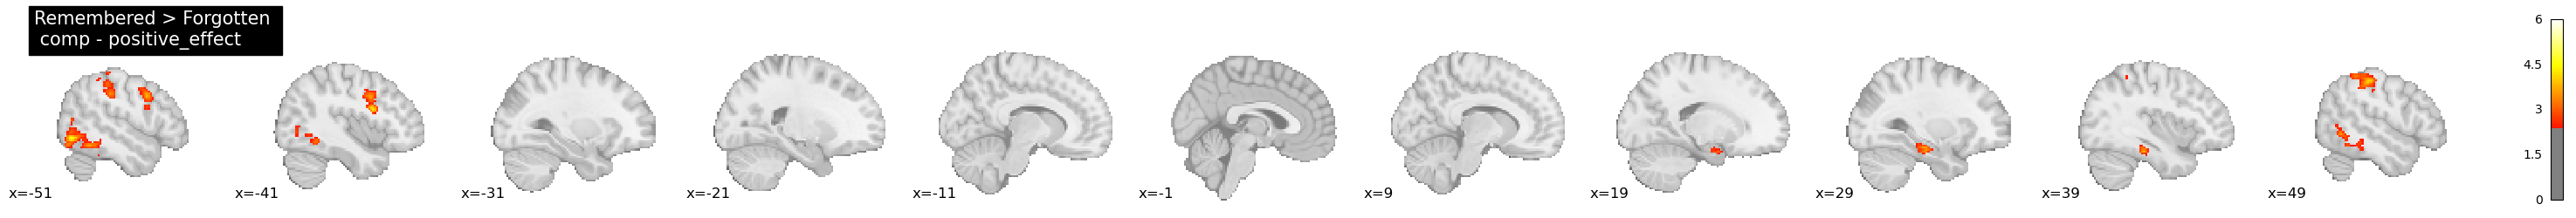

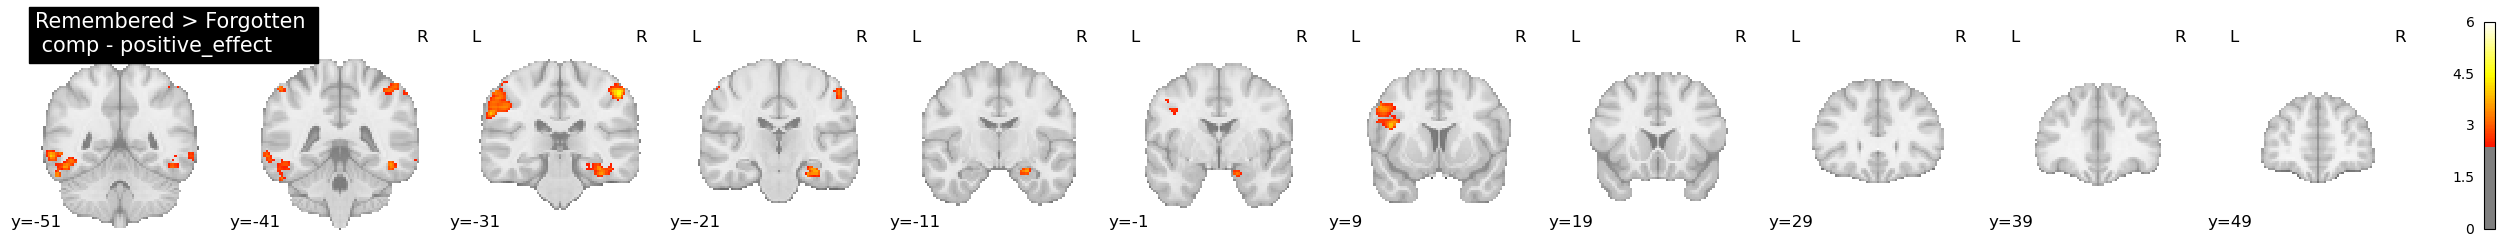

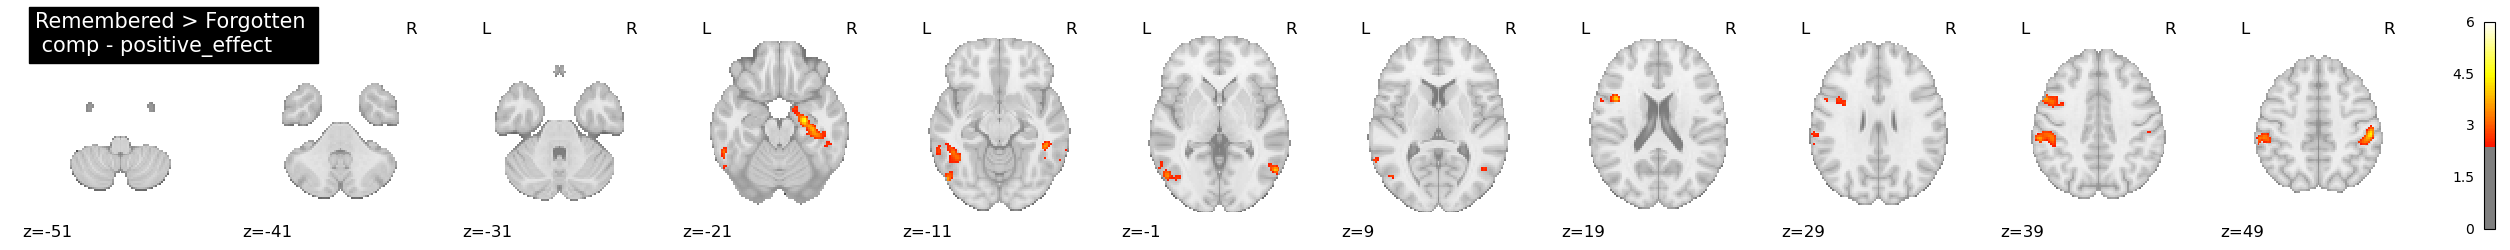

In [14]:
## Examine the whole brain results 
# first look at the comparison youth
tstat_nii_comp = plot_whole_brain_results(group='comp',analysis_type='Imm_Detail',
                         contrast='zstat3',randomise_type='default',tstat_type='cluster_manual_tstat1')

   Cluster Index  Voxels             P  -log10(P)   MAX  MAX X (mm)  \
0              1    3137  1.730000e-11       10.8  5.63          12   

   MAX Y (mm)  MAX Z (mm)  COG X (mm)  COG Y (mm)  COG Z (mm)  
0         -68          22       0.117       -67.6        33.2  


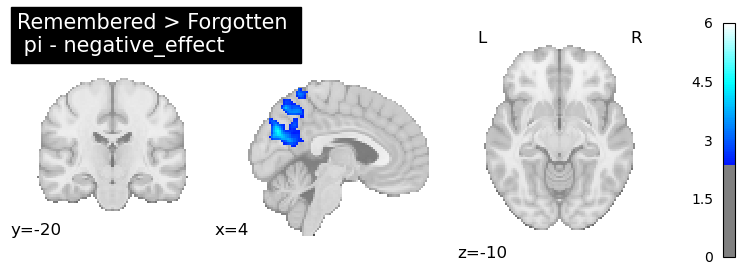

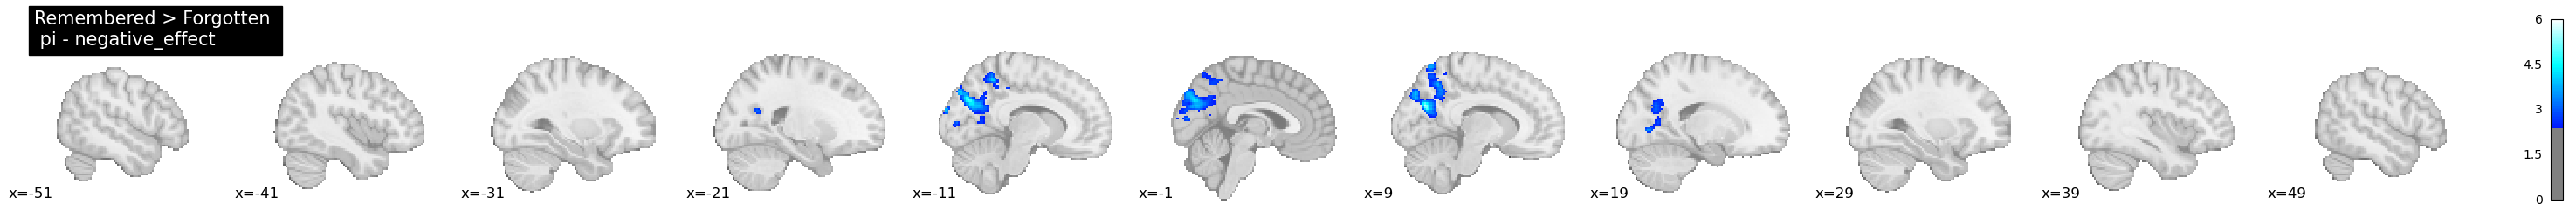

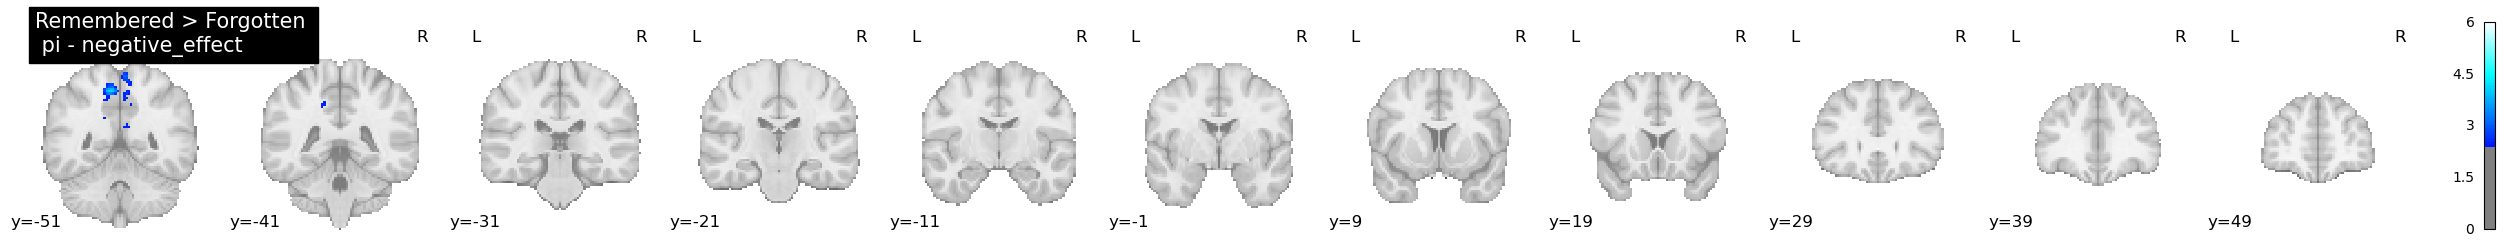

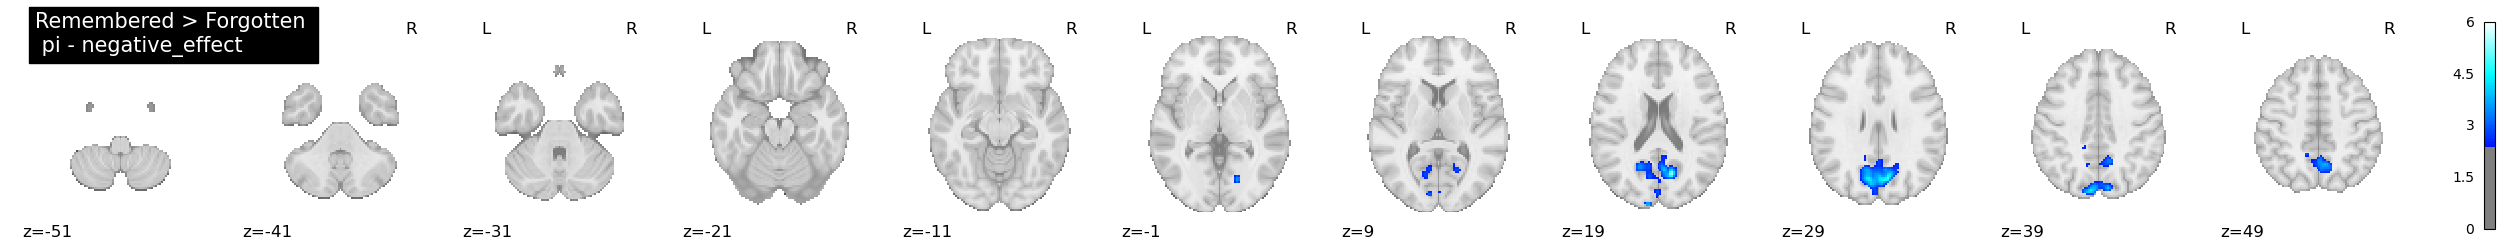

In [15]:
# Then look at the youth with adversity 
tstat_nii_pi = plot_whole_brain_results(group='pi',analysis_type='Imm_Detail',
                         contrast='zstat3',randomise_type='default',tstat_type='cluster_manual_tstat2')

   Cluster Index  Voxels        P  -log10(P)   MAX  MAX X (mm)  MAX Y (mm)  \
0              2    1372  0.00009       4.05  3.82          14         -68   
1              1     629  0.01840       1.74  4.22         -60         -50   

   MAX Z (mm)  COG X (mm)  COG Y (mm)  COG Z (mm)  
0          22        1.92       -62.8        27.6  
1          -4      -57.70       -51.1       -10.3  


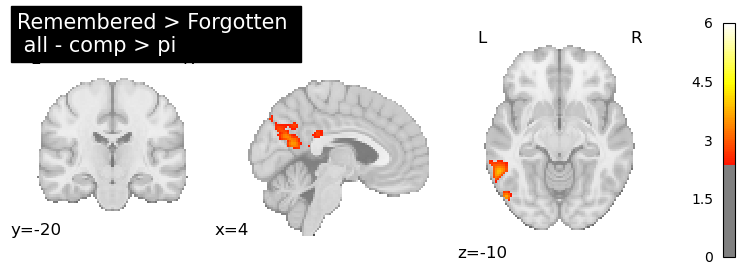

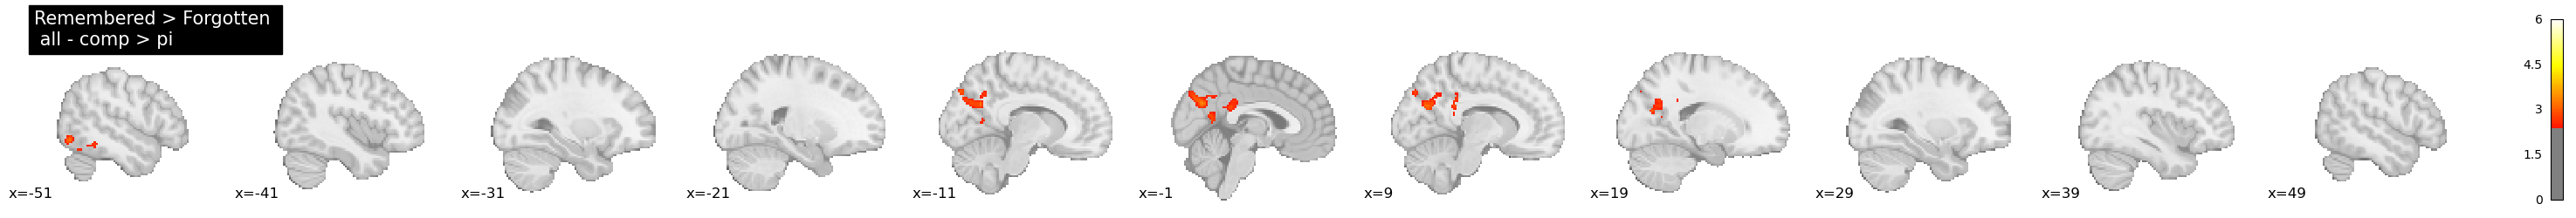

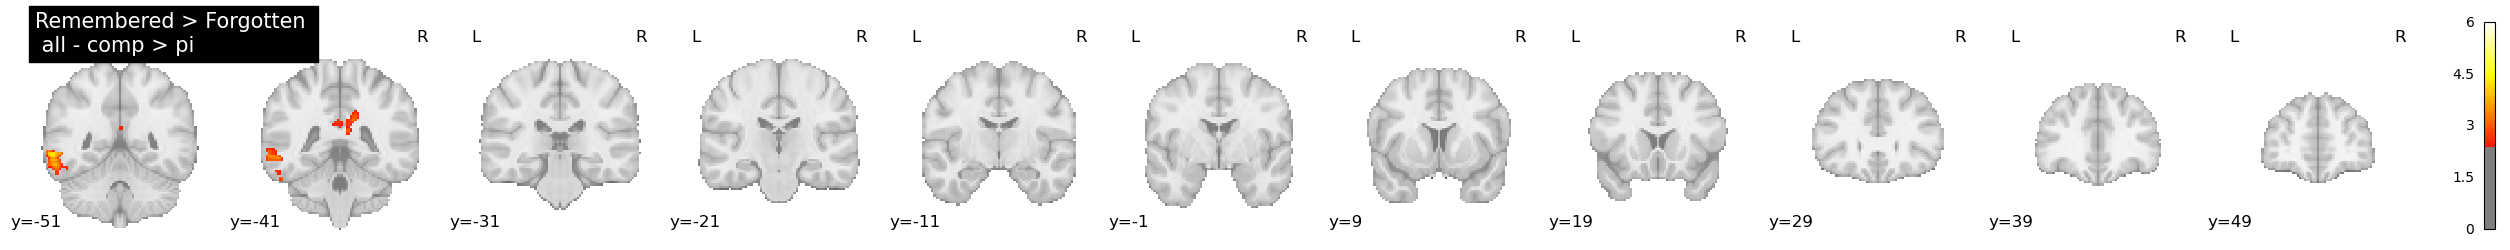

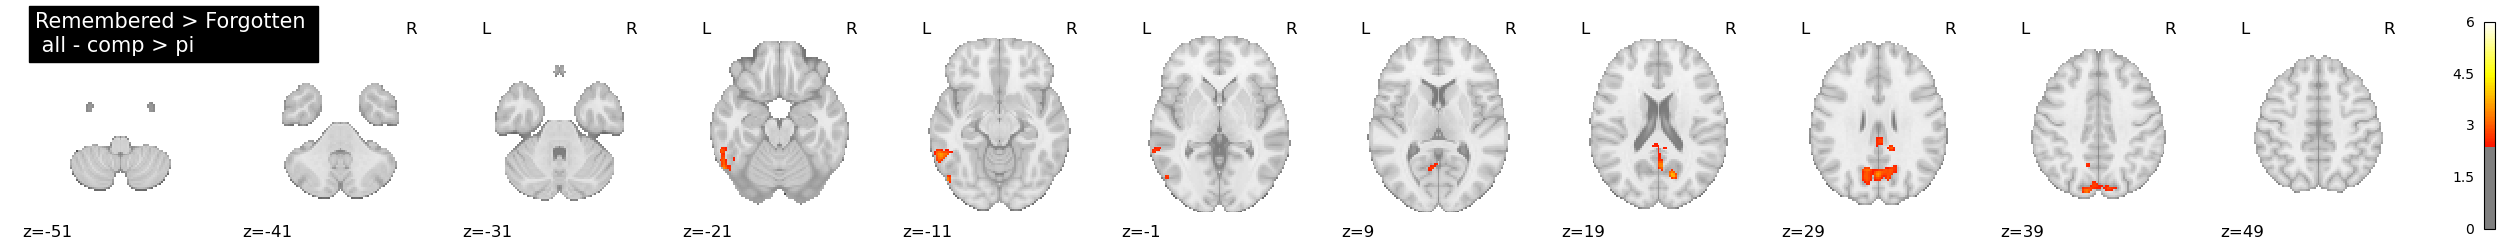

In [16]:
# What is the group difference? (accounting for age)
tstat_nii_group_diff = plot_whole_brain_results(group='all',analysis_type='Imm_Detail',
                         contrast='zstat3',randomise_type='group',tstat_type='cluster_manual_tstat3')

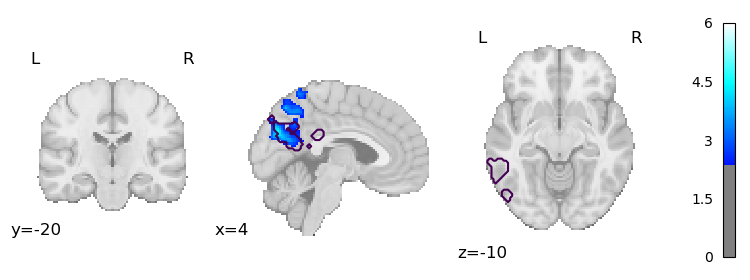

In [17]:
# Plot them both together (as in the paper)
fig = plotting.plot_stat_map(tstat_nii_pi,cut_coords=cut_coords,
                             vmax=vmax,threshold=thresh,cmap='cold_hot_r',draw_cross=False)

# add the group difference over top
fig.add_contours(tstat_nii_group_diff,color='purple',levels=[0])

# save it, apologize that its hard coded
fig.savefig('../plots/Imm_Detail_pi_zstat3_cluster_manual_tstat2_diff_overlay_age_only.svg')

   Cluster Index  Voxels         P  -log10(P)   MAX  MAX X (mm)  MAX Y (mm)  \
0              2    1596  0.000021       4.67  4.52         -32         -76   
1              1     595  0.023800       1.62  4.11         -60         -50   

   MAX Z (mm)  COG X (mm)  COG Y (mm)  COG Z (mm)  
0          44       -9.88       -69.0       32.50  
1          -4      -58.00       -51.4       -9.68  


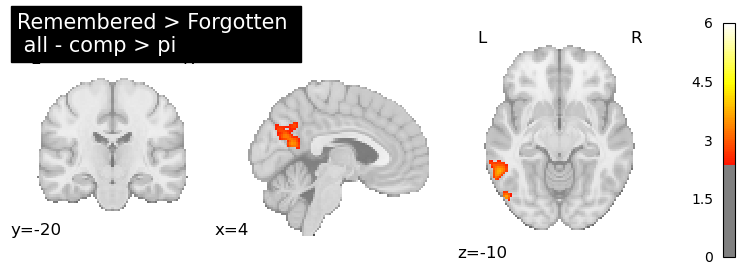

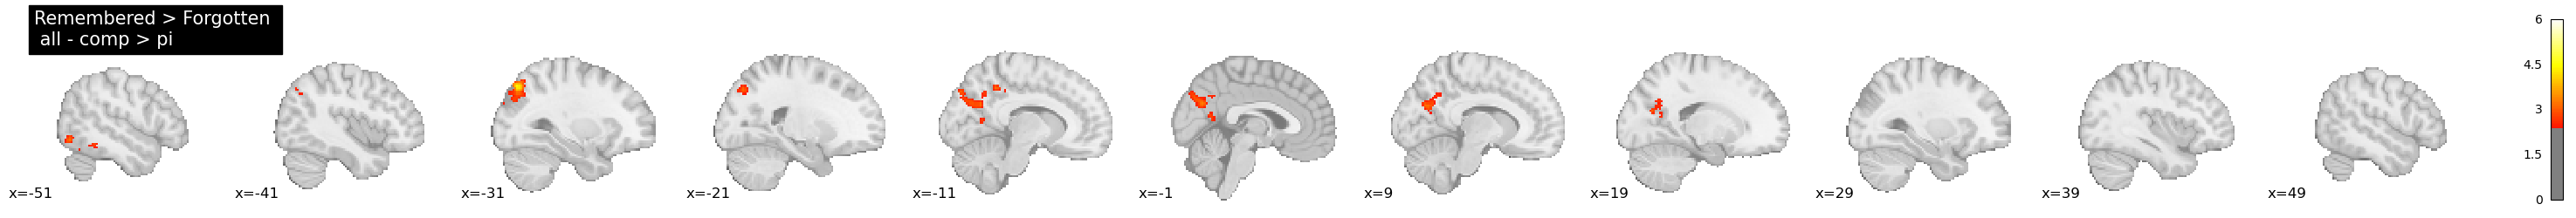

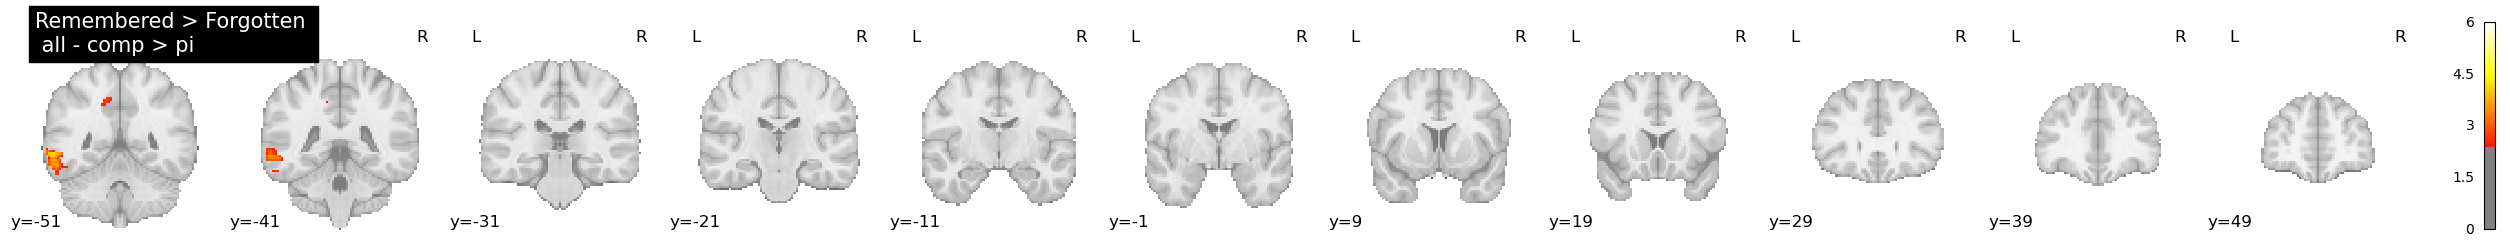

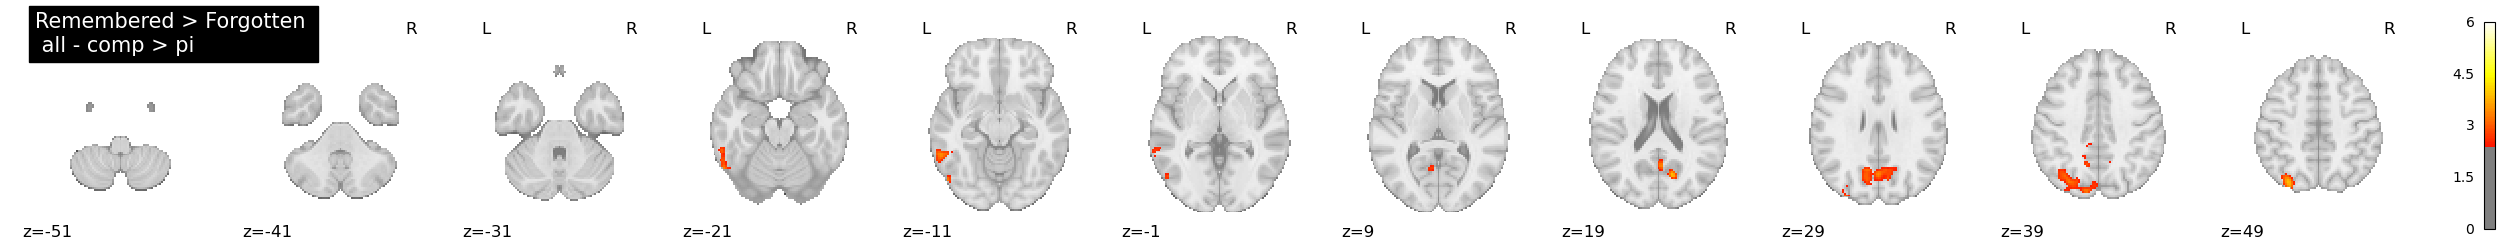

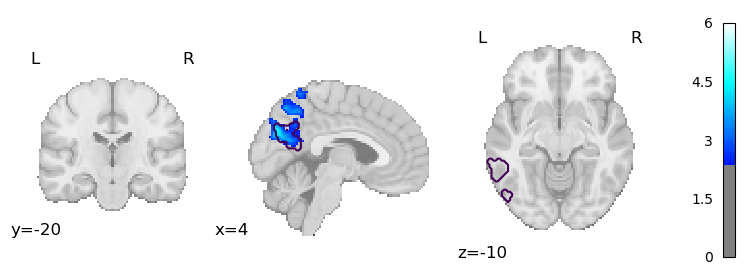

In [18]:
# What is the group difference? (accounting for age AND memory)
tstat_nii_group_diff = plot_whole_brain_results(group='all',analysis_type='Imm_Detail',
                         contrast='zstat3',randomise_type='group_mem',tstat_type='cluster_manual_tstat3')

# Plot them both together (as in the paper)
fig = plotting.plot_stat_map(tstat_nii_pi,cut_coords=cut_coords,
                             vmax=vmax,threshold=thresh,cmap='cold_hot_r',draw_cross=False)

# add the group difference over top
fig.add_contours(tstat_nii_group_diff,color='purple',levels=[0])

# save it, apologize that its hard coded
fig.savefig('../plots/Imm_Detail_pi_zstat3_cluster_manual_tstat2_diff_overlay.svg')

## Memory reinstatement MVPA analyses <a id='mvpa'></a>
What is happening in the brain during the initial encoding of item-location-context associations that children will remember?

In [19]:
analysis_type='trialwise_detailed' # name of the multivariate analysis (immediate detailed memory)

   Cluster Index  Voxels             P  -log10(P)   MAX  MAX X (mm)  \
0              2    3323  8.840000e-13      12.10  5.10          14   
1              1     597  2.680000e-03       2.57  4.87         -50   

   MAX Y (mm)  MAX Z (mm)  COG X (mm)  COG Y (mm)  COG Z (mm)  
0          38          10        7.79        36.3        12.8  
1         -56          48      -46.00       -64.3        42.7  


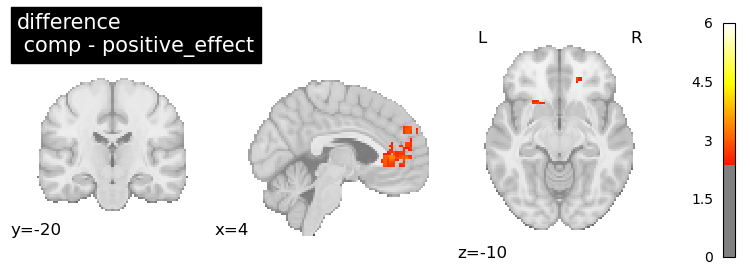

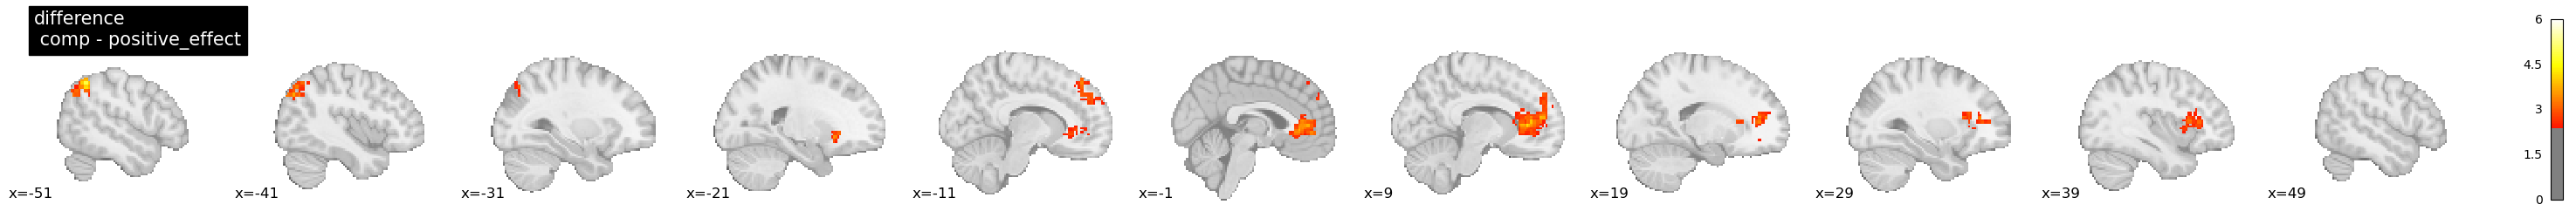

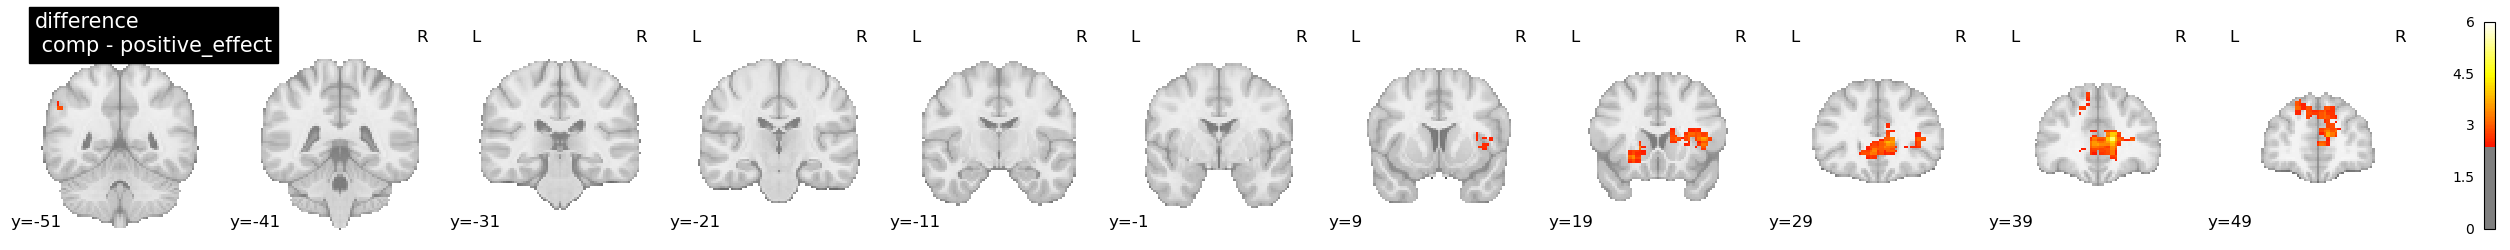

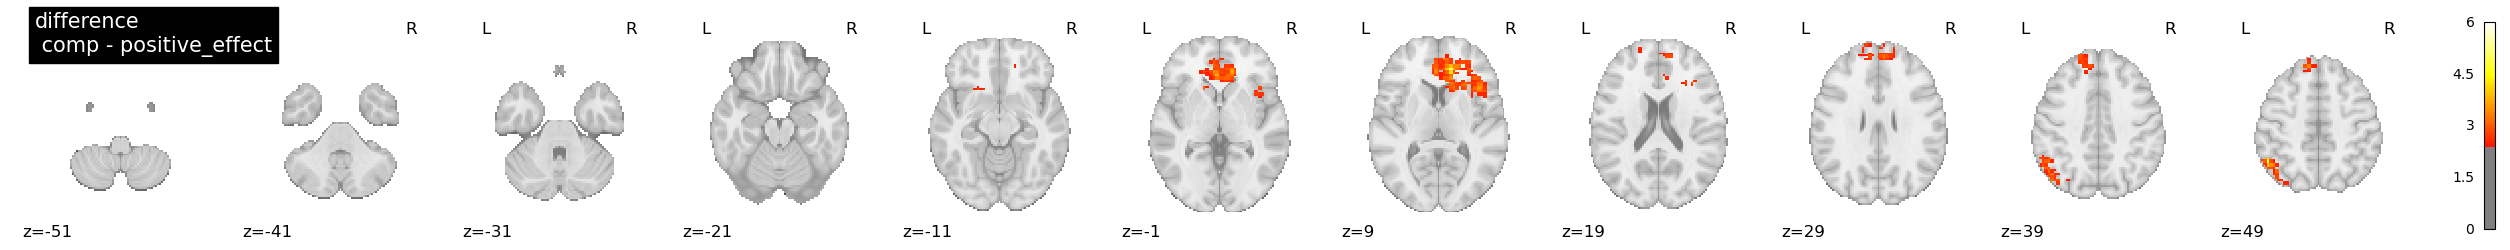

In [20]:
## Examine the whole brain results 
# first look at the comparison youth
tstat_nii_comp = plot_whole_brain_results(group='comp',analysis_type='trialwise_detailed',
                         contrast='difference',randomise_type='default',tstat_type='cluster_manual_tstat1')

   Cluster Index  Voxels             P  -log10(P)   MAX  MAX X (mm)  \
0              1    1401  2.420000e-08       7.62  3.81          48   

   MAX Y (mm)  MAX Z (mm)  COG X (mm)  COG Y (mm)  COG Z (mm)  
0          -2          24        43.6      -0.966        15.6  


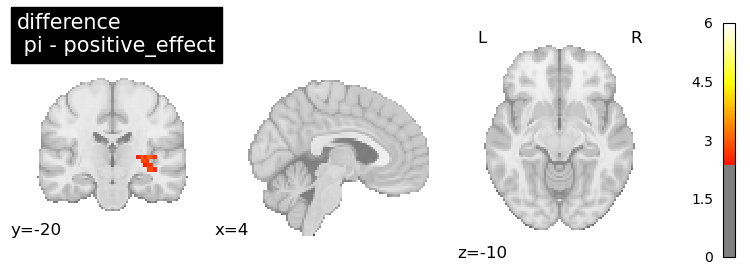

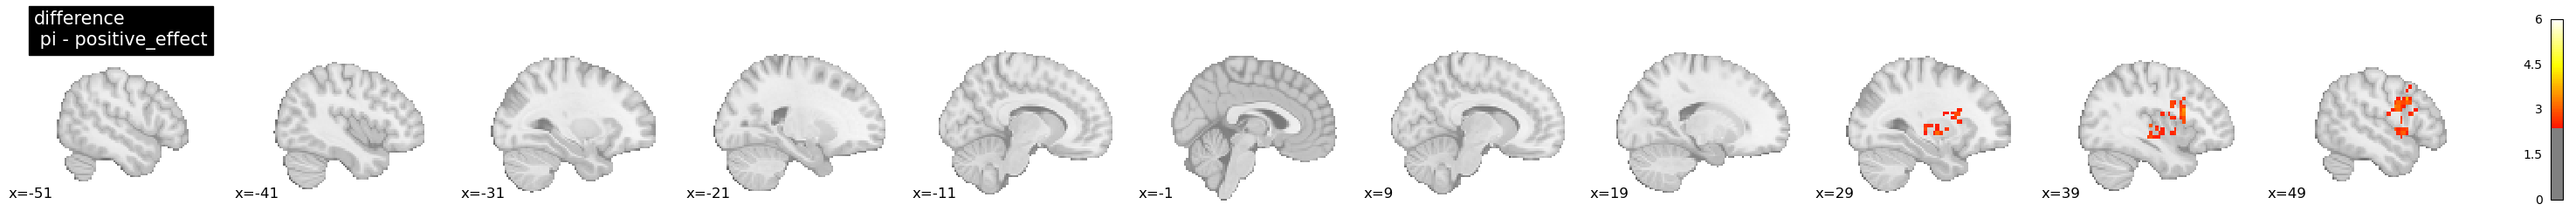

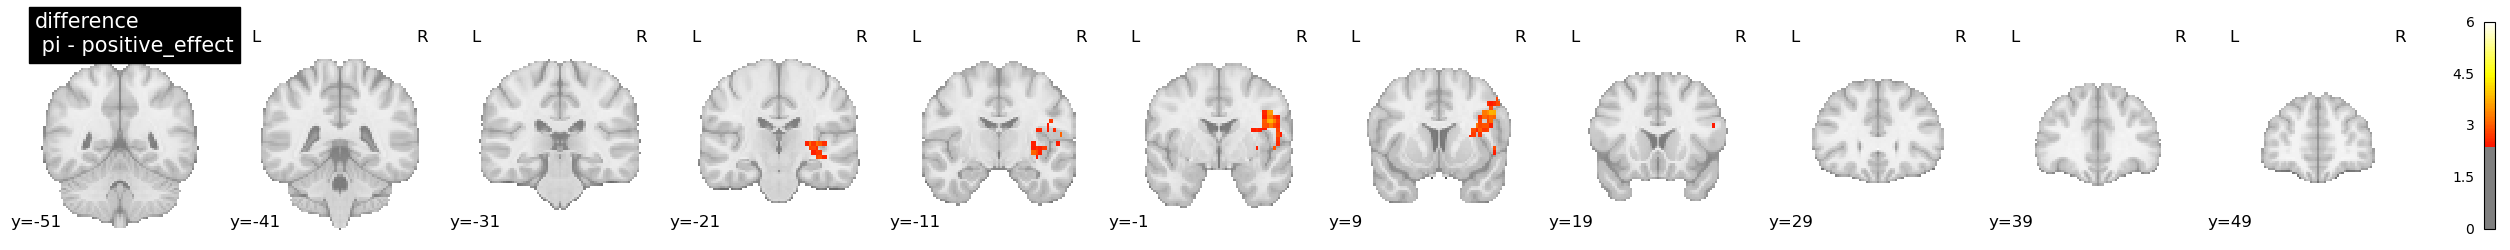

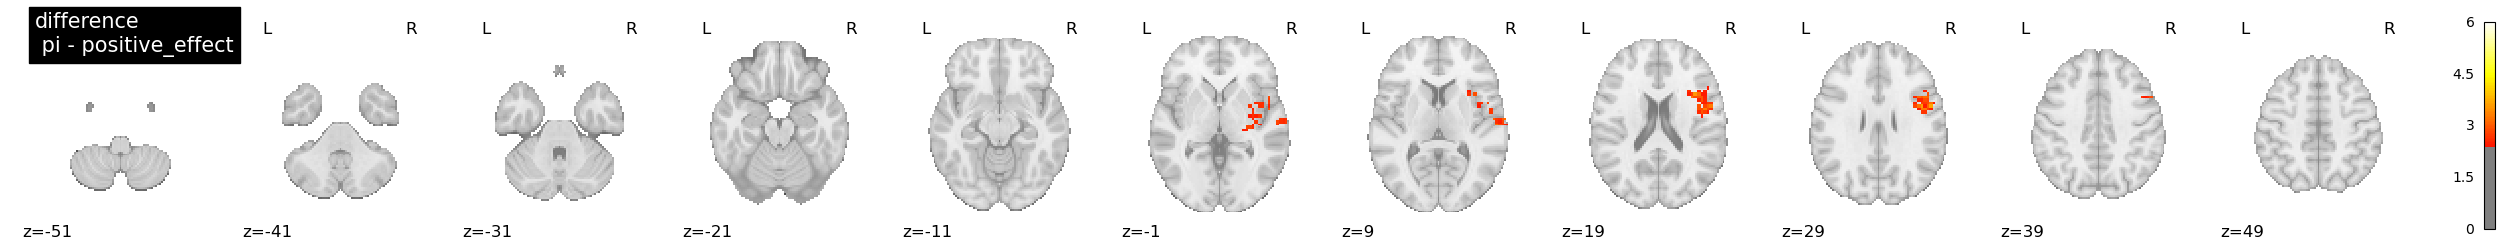

In [21]:
# then look at the youth with adversity
tstat_nii_pi = plot_whole_brain_results(group='pi',analysis_type='trialwise_detailed',
                         contrast='difference',randomise_type='default',tstat_type='cluster_manual_tstat1')

   Cluster Index  Voxels       P  -log10(P)   MAX  MAX X (mm)  MAX Y (mm)  \
0              1     304  0.0328       1.48  3.93         -50         -60   

   MAX Z (mm)  COG X (mm)  COG Y (mm)  COG Z (mm)  
0          52       -38.4       -69.8        46.8  


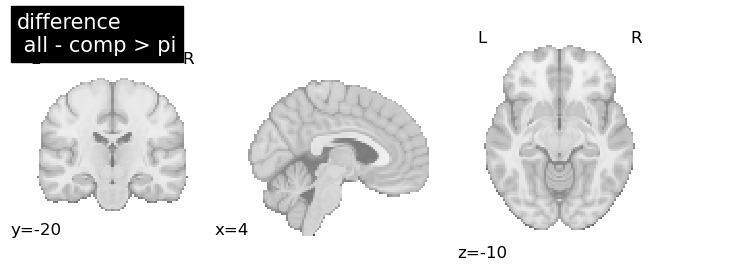

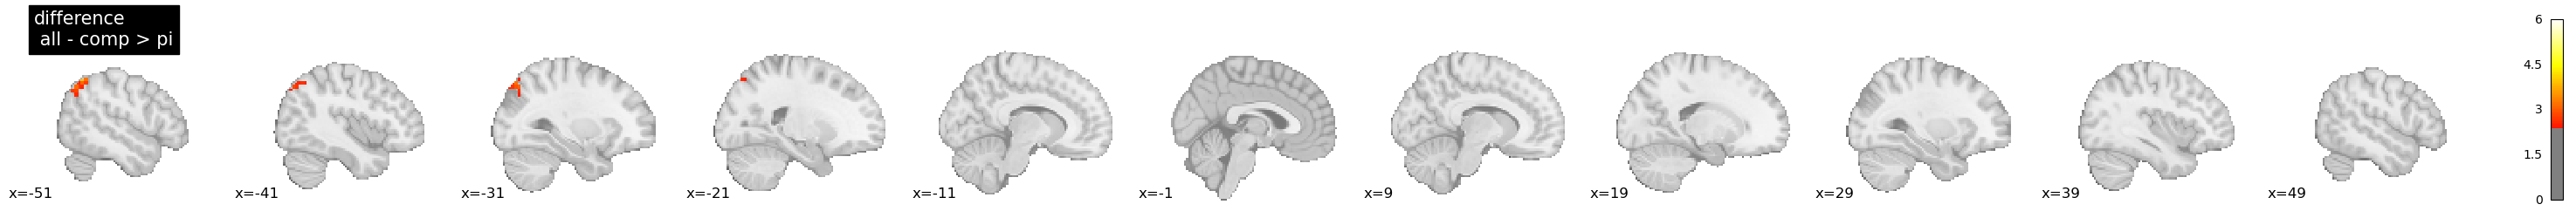

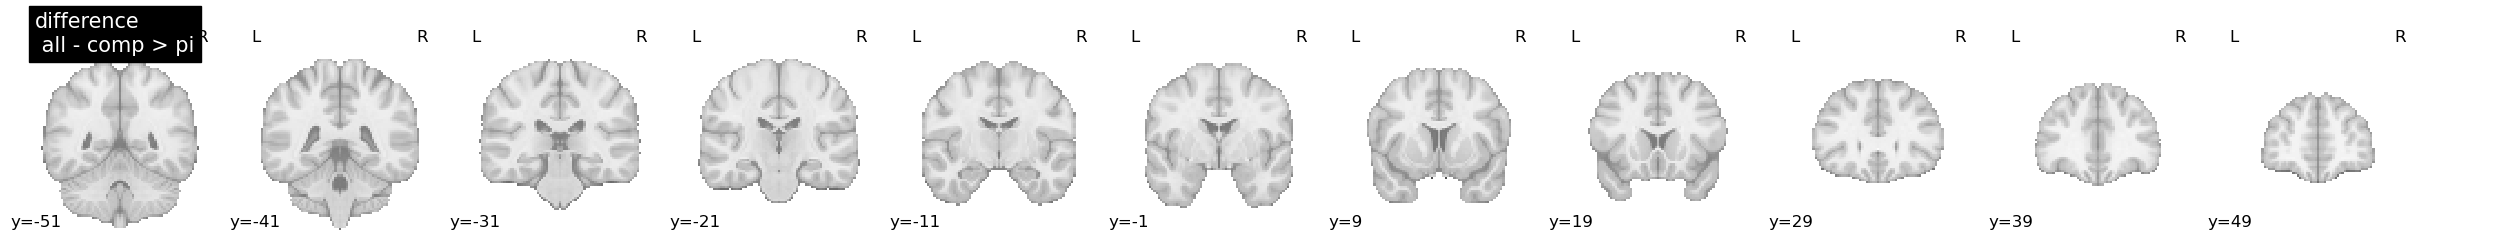

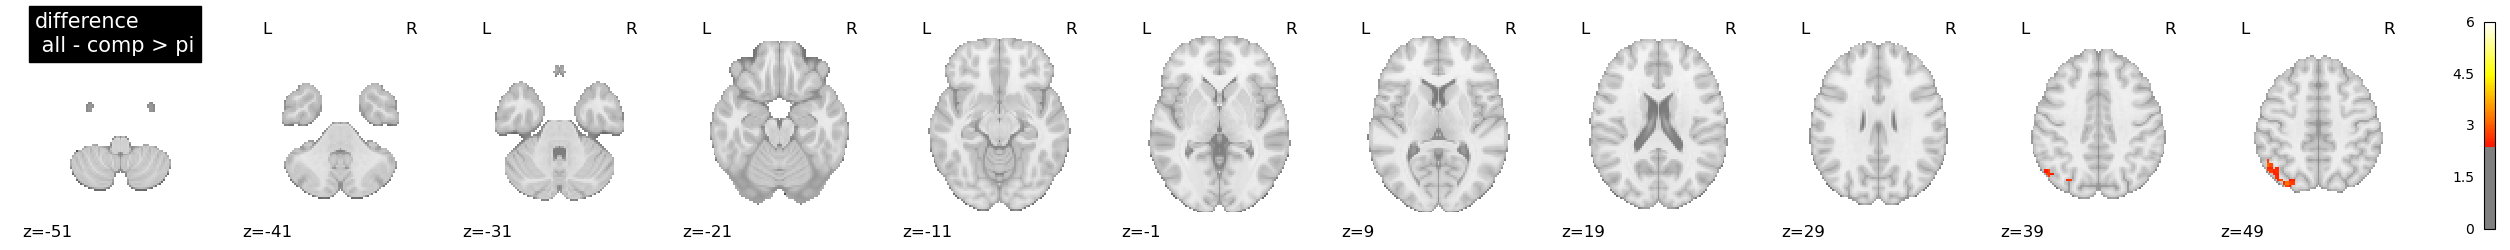

In [22]:
# What is the group difference? (accounting for age only)
tstat_nii_group_diff = plot_whole_brain_results(group='all',analysis_type='trialwise_detailed',
                         contrast='difference',randomise_type='group',tstat_type='cluster_manual_tstat3')

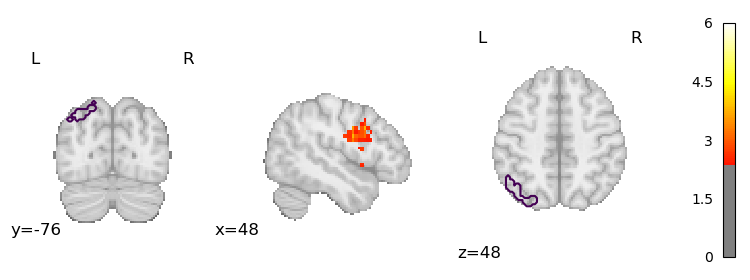

In [23]:
# Plot them both together (as in the paper)
fig = plotting.plot_stat_map(tstat_nii_pi,cut_coords=(48,-76,48),
                             vmax=vmax,threshold=thresh,cmap='cold_hot',draw_cross=False)

# add the group difference over top
fig.add_contours(tstat_nii_group_diff,color='purple',levels=[0])

# save it, apologize that its hard coded
fig.savefig('../plots/trialwise_detailed_pi_difference_cluster_manual_tstat1_diff_overlay_age_only.svg')

Empty DataFrame
Columns: [Cluster Index, Voxels, P, -log10(P), MAX, MAX X (mm), MAX Y (mm), MAX Z (mm), COG X (mm), COG Y (mm), COG Z (mm)]
Index: []


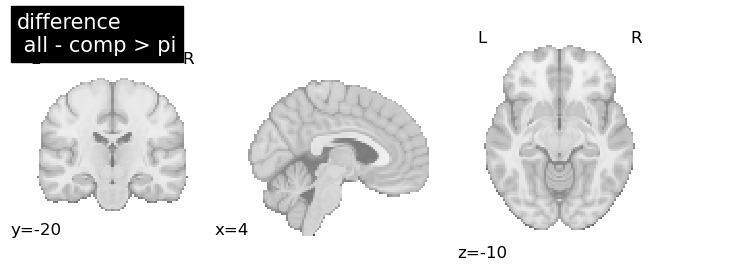

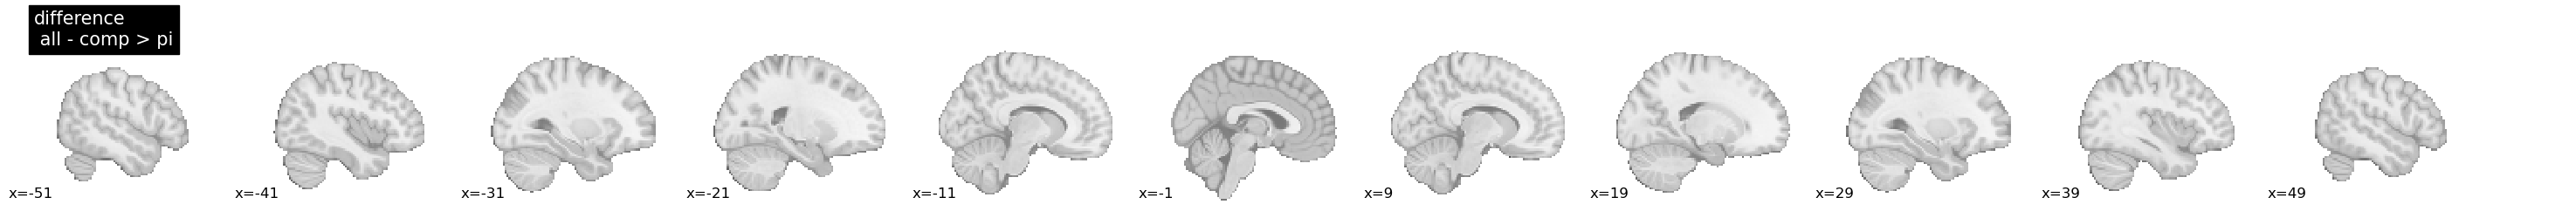

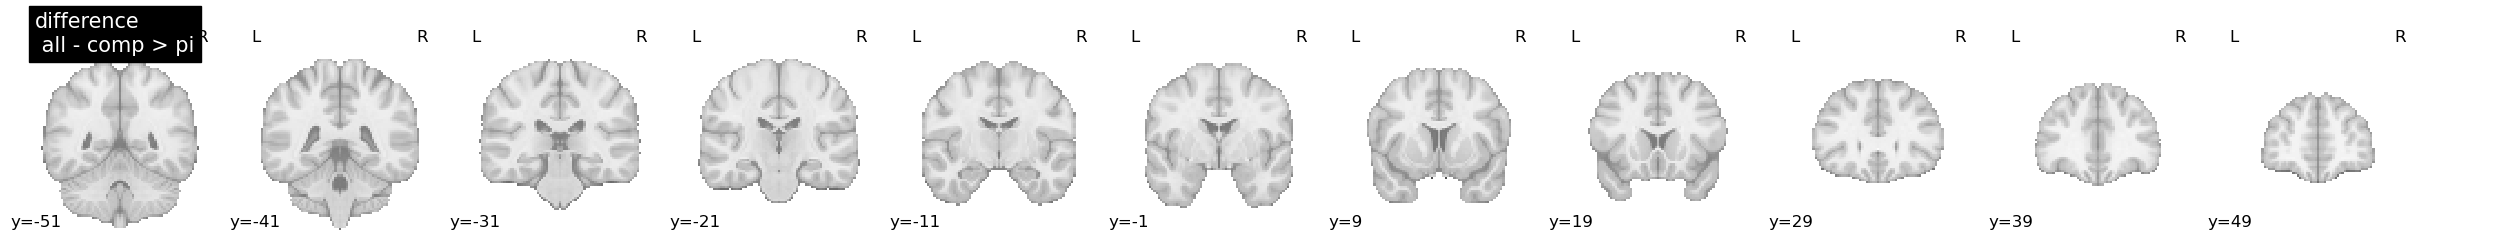

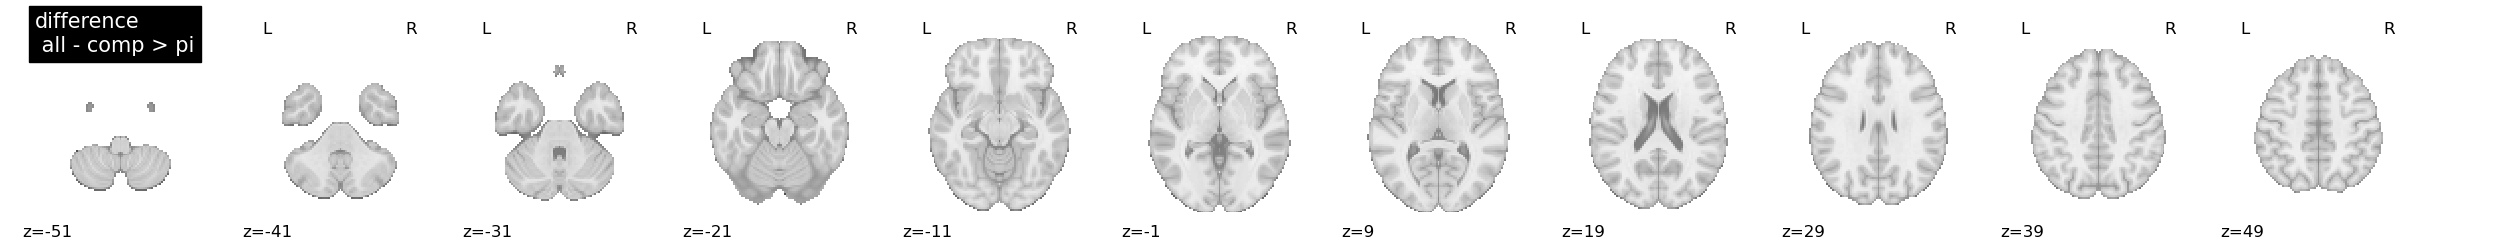

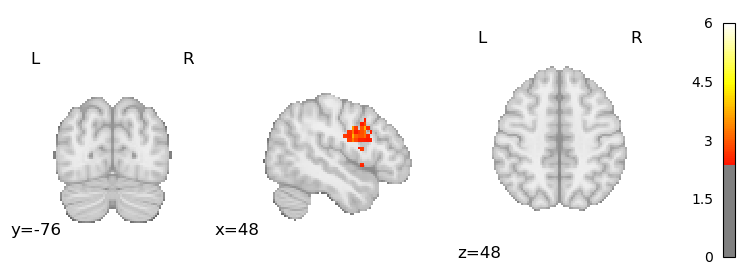

In [24]:
# What is the group difference? (accounting for age and memory)
tstat_nii_group_diff = plot_whole_brain_results(group='all',analysis_type='trialwise_detailed',
                         contrast='difference',randomise_type='group_mem',tstat_type='cluster_manual_tstat3')

# Plot them both together (as in the paper)
fig = plotting.plot_stat_map(tstat_nii_pi,cut_coords=(48,-76,48),
                             vmax=vmax,threshold=thresh,cmap='cold_hot',draw_cross=False)

# add the group difference over top
fig.add_contours(tstat_nii_group_diff,color='purple',levels=[0])

# save it, apologize that its hard coded
fig.savefig('../plots/trialwise_detailed_pi_difference_cluster_manual_tstat1_diff_overlay.svg')

## Group differences in HPC and mPFC <a id='rois'></a>
Let's zoom in on the hippocampus for encoding and mPFC for reinstatement to look at whether there is signal there for the youth with a history of early adversity

### HPC encoding 

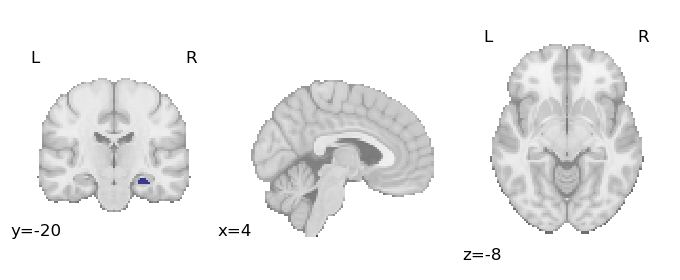

In [25]:
# First load the hippocampal ROI from the GLM analysis 
roi = 'hpc_encoding_comparisons'
roi_nii =nib.load('%s/archive/temp_rois/%s.nii.gz' %(base_dir,roi))
fig = plotting.plot_roi(roi_nii,draw_cross=False,cut_coords=(4,-20,-8))#,cut_coords=(-48,-46,-4))#,colorbar=True)#,cut_coords=(27,-75,-13))
fig.savefig('../plots/%s.svg' %roi)

In [26]:
# Then get the individual subject values to run the analysis 
analysis='Imm_Detail'

zstat_dict=dict() 

# cycle through the zstatistics
zstats=['zstat1','zstat2','zstat3']

for zstat in zstats:
    zstat_dict[zstat]=dict()

    for s, subid in enumerate(data_df.sub_ids):

        # what is the name of the file 
        zstat_file ='%s/%s/Memory_%s.feat/stats/%s.nii.gz' % (fsl_feat_path,subid,analysis,zstat)
        
        # if this file exists 
        if os.path.isfile(zstat_file):
            
            # check that they were included 
            if  float(data_df[data_df.sub_ids==subid].included_encoding)==0:
                print('%s not in fMRI analysis (too much motion)' % subid)
                continue
            
            zstat_nii = nib.load(zstat_file)
            
            # transform it into standard space (it is in native space at the moment)
            zstat_standard = conform(zstat_nii,out_shape=(roi_nii.get_fdata().shape[0],
                                                          roi_nii.get_fdata().shape[1],
                                                          roi_nii.get_fdata().shape[2]),
                                     voxel_size=(roi_nii.affine[0][0],
                                                 roi_nii.affine[1][1],
                                                 roi_nii.affine[2][2]))
            # get the values in the ROI
            zstat_roi = zstat_standard.get_fdata()[roi_nii.get_fdata()==1]
            
            # save to a dictionary 
            zstat_dict[zstat][subid]=np.mean(zstat_roi)

        else:
              print('%s not in fMRI analysis (did not scan or missing anatomical)' %(subid))

    print()

sub-021 not in fMRI analysis (too much motion)
sub-027 not in fMRI analysis (did not scan or missing anatomical)
sub-039 not in fMRI analysis (did not scan or missing anatomical)
sub-114 not in fMRI analysis (too much motion)
sub-121 not in fMRI analysis (too much motion)
sub-124 not in fMRI analysis (too much motion)

sub-021 not in fMRI analysis (too much motion)
sub-027 not in fMRI analysis (did not scan or missing anatomical)
sub-039 not in fMRI analysis (did not scan or missing anatomical)
sub-114 not in fMRI analysis (too much motion)
sub-121 not in fMRI analysis (too much motion)
sub-124 not in fMRI analysis (too much motion)

sub-021 not in fMRI analysis (too much motion)
sub-027 not in fMRI analysis (did not scan or missing anatomical)
sub-039 not in fMRI analysis (did not scan or missing anatomical)
sub-114 not in fMRI analysis (too much motion)
sub-121 not in fMRI analysis (too much motion)
sub-124 not in fMRI analysis (too much motion)



In [27]:
# get all the variables you saved above for the subjects in this analysis
age = [float(data_df.ages[data_df.sub_ids==subid]) for subid in zstat_dict[zstat]]
pi_status = [float(data_df.pi_status[data_df.sub_ids==subid]) for subid in zstat_dict[zstat]]
memory_vals = [float(data_df['detailed_assoc_imm'][data_df.sub_ids==subid]) for subid in zstat_dict[zstat]]

# make a dataframe out of this information 
roi_df = pd.DataFrame({'pi_status':pi_status,'ages':age,
                       'remem':zstat_dict['zstat1'].values(),
                       'forg':zstat_dict['zstat2'].values(),
                       'diff':zstat_dict['zstat3'].values(),
                       'detailed_assoc_imm':memory_vals
                      })
# melt, to help with plotting 
melted_data = roi_df.melt(value_vars=['remem','forg'],id_vars=['pi_status','ages','detailed_assoc_imm'])
melted_data.head()

pi_status   ages  detailed_assoc_imm variable     value
0        0.0   9.98                0.50    remem  1.197352
1        0.0  11.55                0.30    remem -0.150482
2        0.0  14.34                0.35    remem  0.656594
3        0.0  17.61                0.65    remem  2.532872
4        1.0   5.53                0.15    remem -0.614063

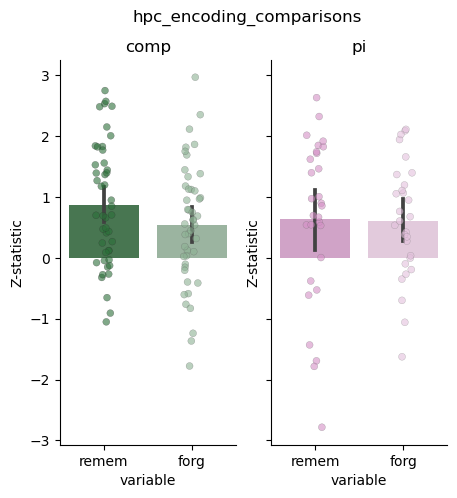

In [28]:
## Plot the remembered and forgotten contrasts for both groups 
palettes=[comp_palette,pi_palette] # combine the palettes 

np.random.seed(0)
fig, ax = plt.subplots(1,2,figsize=(5,5),sharey=True)
fig.suptitle('%s' % roi)
for p, group in enumerate(['comp','pi']):
    
    sns.barplot(x='variable',y='value',data=melted_data[melted_data.pi_status==p],
                alpha=0.9,palette=palettes[p],ax=ax[p])
    sns.stripplot(x='variable',y='value',data=melted_data[melted_data.pi_status==p],
                  alpha=0.6,palette=palettes[p],ax=ax[p],linewidth=0.25)
    ax[p].set_ylabel('Z-statistic')
    ax[p].set_title('%s' % (group))
    
    # Remove the top and right spines
    ax[p].spines["top"].set_visible(False)
    ax[p].spines["right"].set_visible(False)
    
    # add lines connecting remembered and forgotten points (commented out because it is busy!)
#     for sub in range(len(roi_df)):
#         if roi_df.pi_status[sub]==p:
#             ax[p].plot([0,1],[roi_df['remem'][sub],roi_df['forg'][sub]],color='silver',alpha=0.4)

fig.savefig('../plots/%s_%s_group.svg' %(analysis,roi,))

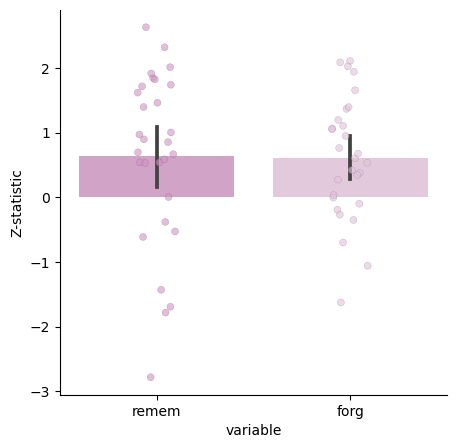

In [29]:
# Plot the PI subjects on their own 
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(x='variable',y='value',data=melted_data[melted_data.pi_status==1],
            alpha=0.9,palette=palettes[1],ax=ax)
sns.stripplot(x='variable',y='value',data=melted_data[melted_data.pi_status==1],
              alpha=0.6,palette=palettes[1],ax=ax,linewidth=0.25)
ax.set_ylabel('Z-statistic')
# Remove the top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# add lines connecting remembered and forgotten points (commented out because it is busy!)
# for sub in range(len(roi_df)):
#     if roi_df.pi_status[sub]==p:
#         ax[p].plot([0,1],[roi_df['remem'][sub],roi_df['forg'][sub]],color='silver',alpha=0.4)

fig.savefig('../plots/%s_%s_pis.svg' %(analysis,roi,))

In [30]:
# Run a difference between groups
# NOTE!! This is kind of an unfair comparison!! 
# The ROI we used was significant in the comparison children, and we are testing it in the PIs. 
# So, differences between groups could be inflated. Hence, we do not include this in the paper. 
# Nonetheless, it is included here for completeness. 

# set up the ANOVA
interX_lm = ols("diff  ~ C(pi_status) + ages", roi_df).fit()
anova_model = sm.stats.anova_lm(interX_lm, typ=3) 

ss_factors = anova_model['sum_sq'][:-1]  # Exclude the residual
ss_error = anova_model['sum_sq'][-1]     # Residual sum of squares

# Calculate partial eta squared for each factor
partial_eta_squared = ss_factors / (ss_factors + ss_error)

# Print partial eta squared as part of the anova
anova_model['part_eta_sq'] = partial_eta_squared
print(anova_model)


# Follow up T-test to check for differences between the two groups 
print('\nFollow up t-test for group differences:')
print(stats.ttest_ind(roi_df['diff'][roi_df['pi_status']==0],
               roi_df['diff'][roi_df['pi_status']==1]))


                 sum_sq    df         F    PR(>F)  part_eta_sq
Intercept      0.003347   1.0  0.004572  0.946280     0.000063
C(pi_status)   1.997315   1.0  2.728510  0.102926     0.036512
ages           0.735038   1.0  1.004128  0.319670     0.013754
Residual      52.705206  72.0       NaN       NaN          NaN

Follow up t-test for group differences:
Ttest_indResult(statistic=1.489015223587583, pvalue=0.14079106388281562)


### mPFC reinstatement 

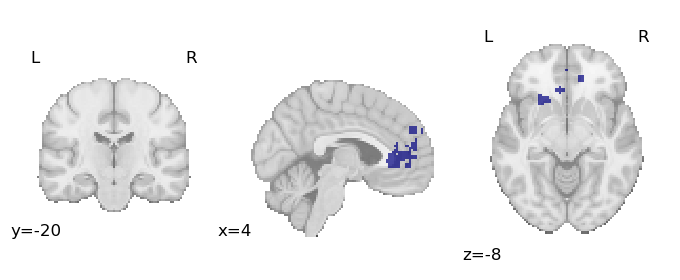

In [31]:
# then lets do this for mpfc
roi = 'mpfc_reinstatement_comparisons_new'
roi_nii =nib.load('%s/archive/temp_rois/%s.nii.gz' %(base_dir,roi))
fig = plotting.plot_roi(roi_nii,draw_cross=False,cut_coords=(4,-20,-8))

fig.savefig('../plots/%s.svg' %roi)

In [32]:
analysis_type='trialwise_detailed'

zstat_dict=dict() 

# remembered vs. forgotten 
zstats=['remembered','forgotten','difference']

for zstat in zstats:
    zstat_dict[zstat]=dict()

    for subid in data_df.sub_ids:

        if float(data_df.included_reinstatement[data_df.sub_ids==subid])==0:
            print('%s not in fMRI analysis (too much motion or missing one or both rest runs)' % subid)
            continue
            
        # get the z stat file 
        zstat_file = '%s/data/similarity_searchlight/%s_%s_%s_summed_zscore_v2.nii.gz' % (base_dir,subid,analysis_type,zstat) 
        
        # this output is already in standard space, so just go ahead and get the values for this ROI
        if os.path.isfile(zstat_file):
            zstat_nii = nib.load(zstat_file)
            zstat_roi = zstat_nii.get_fdata()[roi_nii.get_fdata()==1]
            zstat_dict[zstat][subid]=np.mean(zstat_roi)
    print()

sub-014 not in fMRI analysis (too much motion or missing one or both rest runs)
sub-021 not in fMRI analysis (too much motion or missing one or both rest runs)
sub-027 not in fMRI analysis (too much motion or missing one or both rest runs)
sub-032 not in fMRI analysis (too much motion or missing one or both rest runs)
sub-034 not in fMRI analysis (too much motion or missing one or both rest runs)
sub-039 not in fMRI analysis (too much motion or missing one or both rest runs)
sub-088 not in fMRI analysis (too much motion or missing one or both rest runs)
sub-098 not in fMRI analysis (too much motion or missing one or both rest runs)
sub-100 not in fMRI analysis (too much motion or missing one or both rest runs)
sub-111 not in fMRI analysis (too much motion or missing one or both rest runs)
sub-114 not in fMRI analysis (too much motion or missing one or both rest runs)
sub-116 not in fMRI analysis (too much motion or missing one or both rest runs)
sub-121 not in fMRI analysis (too much m

In [33]:
# get all the variables you saved above for the subjects in this analysis
age = [float(data_df.ages[data_df.sub_ids==subid]) for subid in zstat_dict[zstat]]
pi_status = [float(data_df.pi_status[data_df.sub_ids==subid]) for subid in zstat_dict[zstat]]
memory_vals = [float(data_df['detailed_assoc_imm'][data_df.sub_ids==subid]) for subid in zstat_dict[zstat]]
debrief_vals = [float(data_df['debrief_endorse_memory'][data_df.sub_ids==subid]) for subid in zstat_dict[zstat]]

# make a dataframe out of this information 
roi_df = pd.DataFrame({'pi_status':pi_status,'ages':age,
                       'remem':zstat_dict['remembered'].values(),
                       'forg':zstat_dict['forgotten'].values(),
                       'diff':zstat_dict['difference'].values(),
                       'detailed_assoc_imm':memory_vals,
                       'debrief_endorse_memory':debrief_vals
                      })

# melt, to help with plotting
melted_data= roi_df.melt(value_vars=['remem','forg'],id_vars=['pi_status','ages','detailed_assoc_imm',
                                                             'debrief_endorse_memory'])
melted_data.head()

pi_status   ages  detailed_assoc_imm  debrief_endorse_memory variable  \
0        0.0   9.98                0.50                     NaN    remem   
1        0.0  11.55                0.30                     NaN    remem   
2        0.0  14.34                0.35                     1.0    remem   
3        0.0  17.61                0.65                     1.0    remem   
4        1.0   5.53                0.15                     NaN    remem   

       value  
0 -17.491424  
1 -10.834632  
2  -0.895786  
3 -11.038180  
4  -9.954858

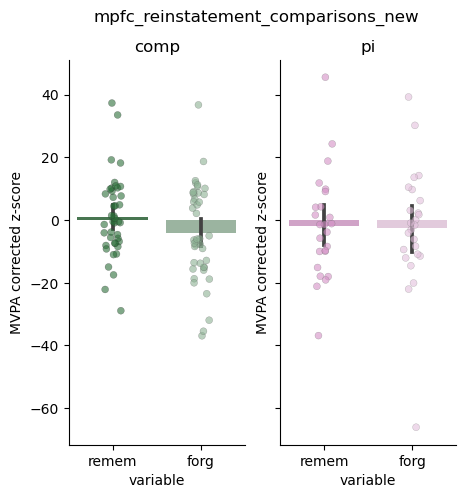

In [34]:
## Plot the remembered and forgotten contrasts for both groups 
palettes=[comp_palette,pi_palette] # combine the palettes 

np.random.seed(0)
fig, ax = plt.subplots(1,2,figsize=(5,5),sharey=True)
fig.suptitle('%s' % roi)
for p, group in enumerate(['comp','pi']):
    
    sns.barplot(x='variable',y='value',data=melted_data[melted_data.pi_status==p],
                alpha=0.9,palette=palettes[p],ax=ax[p])
    sns.stripplot(x='variable',y='value',data=melted_data[melted_data.pi_status==p],
                  alpha=0.6,palette=palettes[p],ax=ax[p],linewidth=0.25)
    ax[p].set_ylabel('MVPA corrected z-score')
    ax[p].set_title('%s' % (group))
    # Remove the top and right spines
    ax[p].spines["top"].set_visible(False)
    ax[p].spines["right"].set_visible(False)
    
    # add lines connecting remembered and forgotten points (commented out because it is busy!)
#     for sub in range(len(roi_df)):
#         if roi_df.pi_status[sub]==p:
#             ax[p].plot([0,1],[roi_df['remem'][sub],roi_df['forg'][sub]],color='silver',alpha=0.4)

fig.savefig('../plots/mvpa_%s_%s_group.svg' %(analysis_type,roi,))

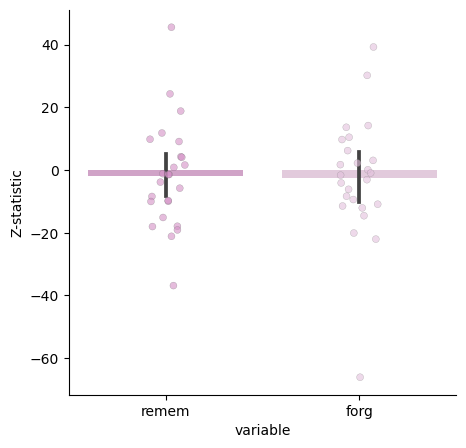

In [35]:
# Now plot the pis separately 
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(x='variable',y='value',data=melted_data[melted_data.pi_status==1],
            alpha=0.9,palette=palettes[1],ax=ax)
sns.stripplot(x='variable',y='value',data=melted_data[melted_data.pi_status==1],
              alpha=0.6,palette=palettes[1],ax=ax,linewidth=0.25)
ax.set_ylabel('Z-statistic')
# Remove the top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# add lines connecting remembered and forgotten points (commented out because it is busy!)
# for sub in range(len(roi_df)):
#     if roi_df.pi_status[sub]==p:
#         ax[p].plot([0,1],[roi_df['remem'][sub],roi_df['forg'][sub]],color='silver',alpha=0.4)

fig.savefig('../plots/mvpa_%s_%s_pis.svg' %(analysis_type,roi,))

In [36]:
# Run a difference between groups
# NOTE!! This is kind of an unfair comparison!! 
# The ROI we used was significant in the comparison children, and we are testing it in the PIs. 
# So, differences between groups could be inflated. Hence, we do not include this in the paper. 
# Nonetheless, it is included here for completeness. 

# set up the ANOVA
interX_lm = ols("diff  ~ C(pi_status) + ages", roi_df).fit()
anova_model = sm.stats.anova_lm(interX_lm, typ=3) 

ss_factors = anova_model['sum_sq'][:-1]  # Exclude the residual
ss_error = anova_model['sum_sq'][-1]     # Residual sum of squares

# Calculate partial eta squared for each factor
partial_eta_squared = ss_factors / (ss_factors + ss_error)

# Print partial eta squared as part of the anova
anova_model['part_eta_sq'] = partial_eta_squared
print(anova_model)


# Follow up T-test to check for differences between the two groups 
print('\nFollow up t-test for group differences:')
print(stats.ttest_ind(roi_df['diff'][roi_df['pi_status']==0],
               roi_df['diff'][roi_df['pi_status']==1]))

                   sum_sq    df         F    PR(>F)  part_eta_sq
Intercept      411.391629   1.0  5.474751  0.022425     0.078802
C(pi_status)    97.222663   1.0  1.293828  0.259584     0.019815
ages           108.825303   1.0  1.448234  0.233244     0.022128
Residual      4809.180113  64.0       NaN       NaN          NaN

Follow up t-test for group differences:
Ttest_indResult(statistic=1.4678301123522806, pvalue=0.14697290629130327)


Also, was there any difference in reinstatement based on whether the participants said that they thought about the memory task during the rest period? 

no_spont_mem 35
spont_mem 18


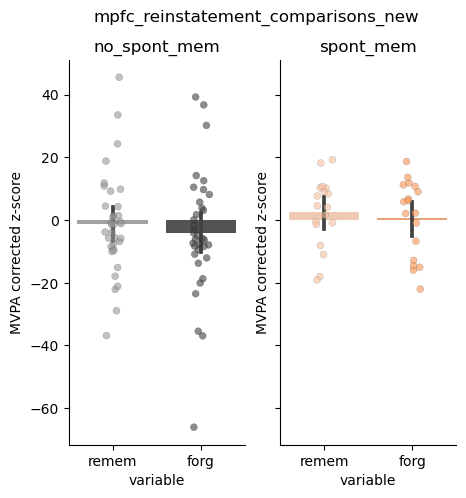

In [37]:
## Plot the remembered and forgotten contrasts, now by whether or not they spontaneously had memory 
palettes=[nothought_palette,thought_palette] # combine the palettes

np.random.seed(0)
fig, ax = plt.subplots(1,2,figsize=(5,5),sharey=True)
fig.suptitle('%s' % roi)
for p, group in enumerate(['no_spont_mem','spont_mem']):
    
    print(group,len(roi_df[roi_df.debrief_endorse_memory==p]))
    sns.barplot(x='variable',y='value',data=melted_data[melted_data.debrief_endorse_memory==p],
                alpha=0.9,palette=palettes[p],ax=ax[p])
    sns.stripplot(x='variable',y='value',data=melted_data[melted_data.debrief_endorse_memory==p],
                  alpha=0.6,palette=palettes[p],ax=ax[p],linewidth=0.25)
    ax[p].set_ylabel('MVPA corrected z-score')
    ax[p].set_title('%s' % (group))
    # Remove the top and right spines
    ax[p].spines["top"].set_visible(False)
    ax[p].spines["right"].set_visible(False)

    # add lines connecting remembered and forgotten points (commented out because it is busy!)
#     for sub in range(len(roi_df)):
#         if roi_df.pi_status[sub]==p:
#             ax[p].plot([0,1],[roi_df['remem'][sub],roi_df['forg'][sub]],color='silver',alpha=0.4)

fig.savefig('../plots/mvpa_%s_%s_debrief.svg' %(analysis_type,roi,))

In [38]:
# Now test for any group differences and interactions
# set up the ANOVA
interX_lm = ols("diff  ~ ages + C(debrief_endorse_memory)", roi_df).fit()
anova_model = sm.stats.anova_lm(interX_lm, typ=3) 

ss_factors = anova_model['sum_sq'][:-1]  # Exclude the residual
ss_error = anova_model['sum_sq'][-1]     # Residual sum of squares

# Calculate partial eta squared for each factor
partial_eta_squared = ss_factors / (ss_factors + ss_error)

# Print partial eta squared as part of the anova
anova_model['part_eta_sq'] = partial_eta_squared
print(anova_model)

# Follow up T-test to check for differences between the two groups 
print('\nFollow up t-test for group differences:')
print(stats.ttest_ind(roi_df['diff'][roi_df.debrief_endorse_memory==0],
                      roi_df['diff'][roi_df.debrief_endorse_memory==1]))

                                sum_sq    df         F    PR(>F)  part_eta_sq
Intercept                   397.928095   1.0  5.610543  0.021758     0.100890
C(debrief_endorse_memory)    58.254056   1.0  0.821347  0.369134     0.016161
ages                        217.533004   1.0  3.067082  0.086025     0.057796
Residual                   3546.253138  50.0       NaN       NaN          NaN

Follow up t-test for group differences:
Ttest_indResult(statistic=0.598478253304931, pvalue=0.5521697670065383)


## Control analysis: motion <a id='motion'></a>

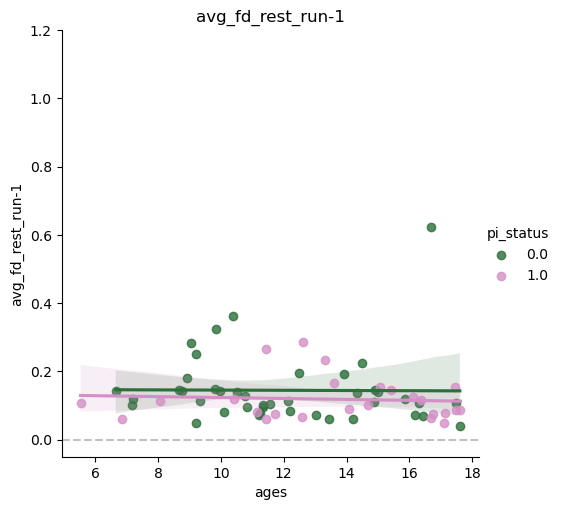

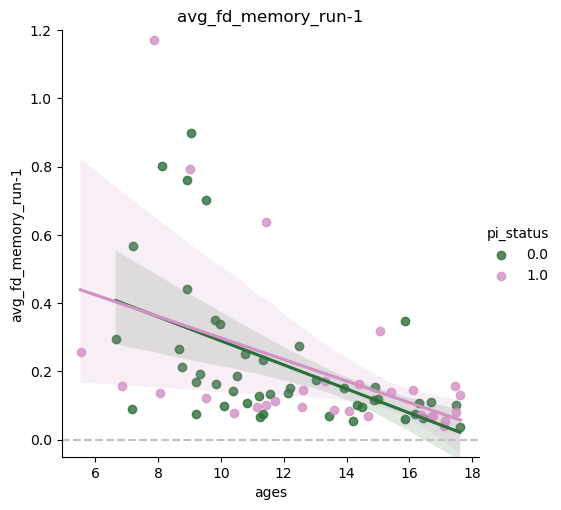

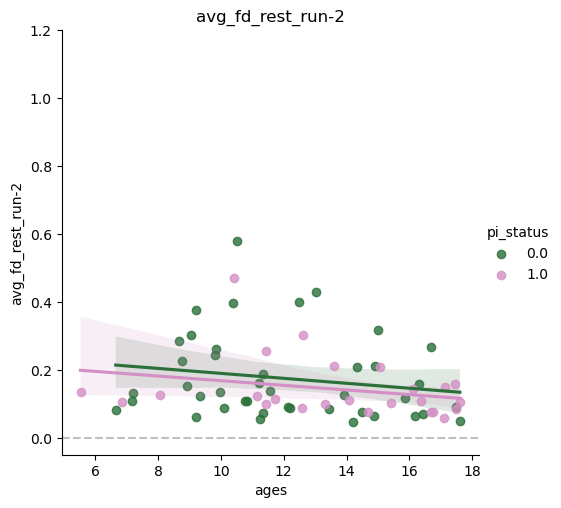

In [39]:
# plot the motion for the different phases of the experiment
# NOTE: this is for the included children only 
for fd_type in ['avg_fd_rest_run-1','avg_fd_memory_run-1','avg_fd_rest_run-2']:
    
    # only take the subjects that are usable for the particular analysis that uses that run 
    if 'rest' in fd_type:
        temp_df = data_df[data_df['included_reinstatement']==1]
    else:
        temp_df = data_df[data_df['included_encoding']==1]

    fig = sns.lmplot(x='ages',y=fd_type,hue='pi_status',data=temp_df,palette=colors)
    plt.axhline(0,linestyle='dashed',color='silver')
    plt.title(fd_type)
    plt.ylim(-0.05,1.2)
    
    fig.savefig('../plots/framewise_disp_%s.svg' %(fd_type,))

In [40]:
# test for any differences across groups
for fd_type in ['avg_fd_rest_run-1','avg_fd_memory_run-1','avg_fd_rest_run-2']:

    print(fd_type)
        
     # only take the subjects that are usable for the analysis 
    if 'rest' in fd_type:
        temp_df = data_df[data_df['included_reinstatement']==1]
    else:
        temp_df = data_df[data_df['included_encoding']==1]
        
    temp_df= temp_df.rename(columns={fd_type:fd_type.replace('-','_')})

    interX_lm = ols("%s ~ C(pi_status) +ages + C(pi_status)*ages" %(fd_type.replace('-','_')), temp_df).fit()
    anova_model = sm.stats.anova_lm(interX_lm, typ=3) 
    
    ss_factors = anova_model['sum_sq'][:-1]  # Exclude the residual
    ss_error = anova_model['sum_sq'][-1]     # Residual sum of squares

    # Calculate partial eta squared for each factor
    partial_eta_squared = ss_factors / (ss_factors + ss_error)

    # Print partial eta squared as part of the anova
    anova_model['part_eta_sq'] = partial_eta_squared
    print(anova_model)
    print()
    
    print('Corr with age in comp:',stats.pearsonr(temp_df['ages'][temp_df.pi_status==0],
                         temp_df[fd_type.replace('-','_')][temp_df.pi_status==0]))

    print('Corr with age in pi:',stats.pearsonr(temp_df['ages'][temp_df.pi_status==1],
                         temp_df[fd_type.replace('-','_')][temp_df.pi_status==1]))

    print()

avg_fd_rest_run-1
                     sum_sq    df         F    PR(>F)  part_eta_sq
Intercept          0.052767   1.0  6.244342  0.015079     0.090178
C(pi_status)       0.000112   1.0  0.013301  0.908550     0.000211
ages               0.000032   1.0  0.003779  0.951174     0.000060
C(pi_status):ages  0.000183   1.0  0.021702  0.883352     0.000344
Residual           0.532370  63.0       NaN       NaN          NaN

Corr with age in comp: (-0.008545427961683824, 0.9571659643723303)
Corr with age in pi: (-0.07432325112186061, 0.7240286153339032)

avg_fd_memory_run-1
                     sum_sq    df          F    PR(>F)  part_eta_sq
Intercept          1.132073   1.0  28.319948  0.000001     0.285139
C(pi_status)       0.000891   1.0   0.022281  0.881766     0.000314
ages               0.512804   1.0  12.828295  0.000621     0.153031
C(pi_status):ages  0.002544   1.0   0.063647  0.801551     0.000896
Residual           2.838184  71.0        NaN       NaN          NaN

Corr with age in c

## Control analysis: task activation <a id='task'></a>

   Cluster Index  Voxels             P  -log10(P)    MAX  MAX X (mm)  \
0              4   36341  2.850000e-26      25.50  23.10          20   
1              3    5735  2.380000e-07       6.62   8.94          30   
2              2    2507  5.490000e-04       3.26   7.95         -42   
3              1    1463  1.250000e-02       1.90   6.46          -8   

   MAX Y (mm)  MAX Z (mm)  COG X (mm)  COG Y (mm)  COG Z (mm)  
0         -82         -10        1.78      -63.70        3.04  
1          34         -12       24.00       18.70       15.70  
2           0          36      -41.00        5.06       36.60  
3          14          48       -0.92       20.00       43.80  


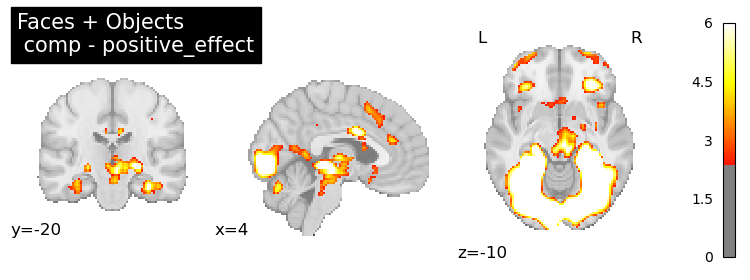

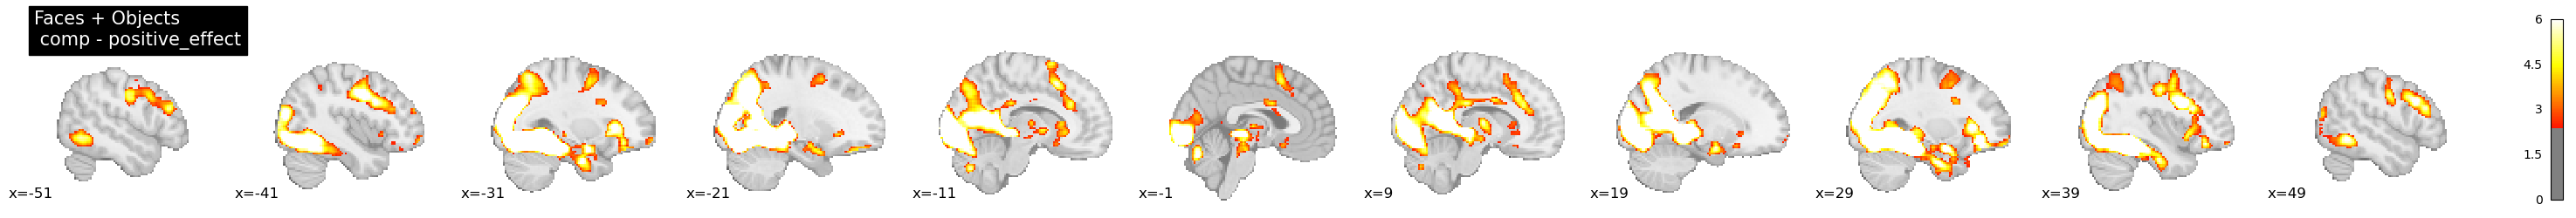

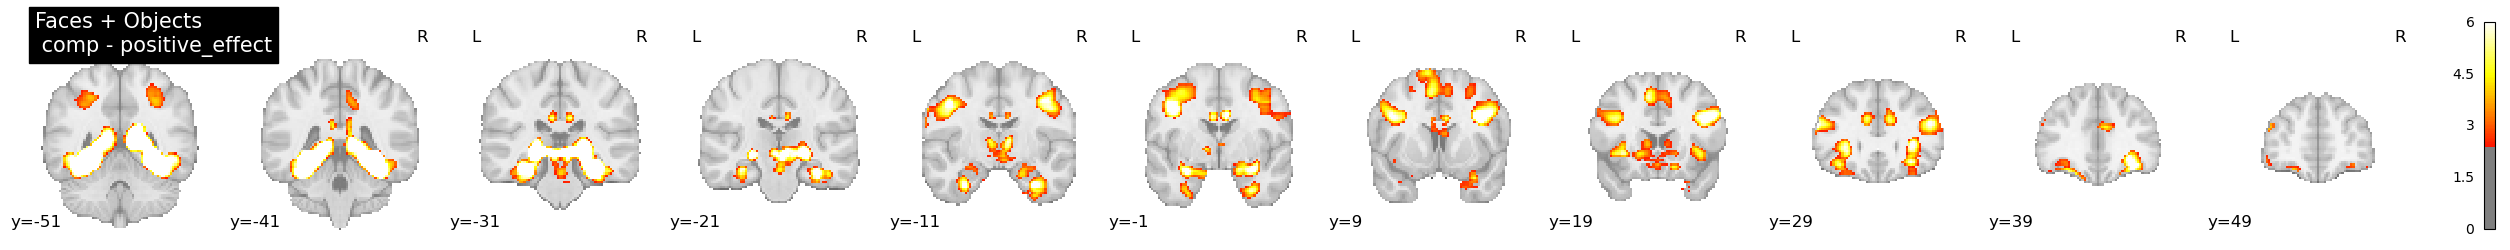

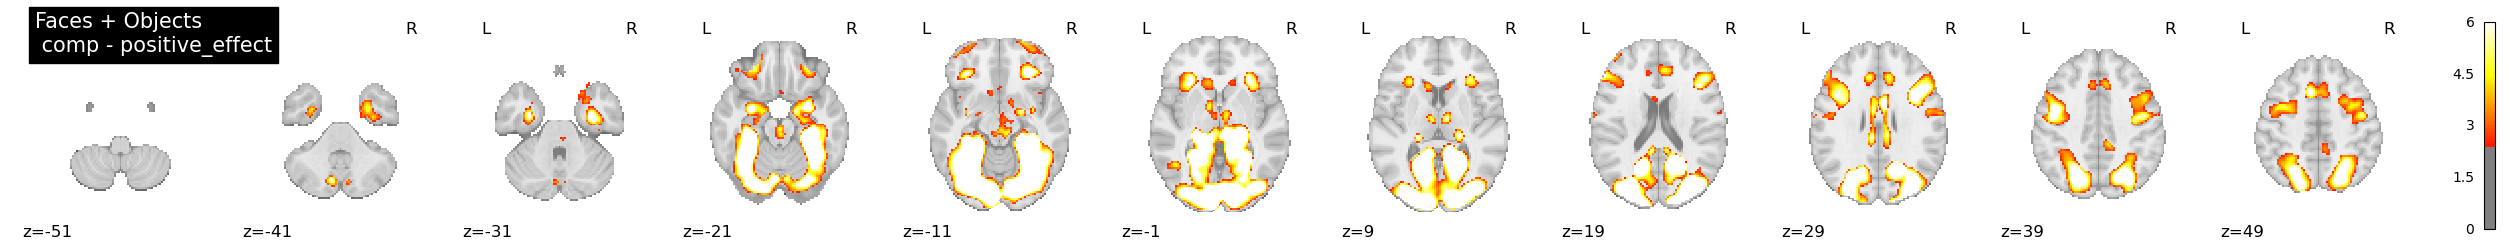

In [41]:
## Examine the whole brain results 
# first look at the comparison youth
tstat_nii_comp = plot_whole_brain_results(group='comp',analysis_type='FaceObject',
                         contrast='zstat4',randomise_type='default',tstat_type='cluster_manual_tstat1')


   Cluster Index  Voxels             P  -log10(P)    MAX  MAX X (mm)  \
0              3   28247  1.610000e-25      24.80  10.30          32   
1              2    3043  2.650000e-05       4.58   7.18          38   
2              1    1966  8.260000e-04       3.08   5.09         -38   

   MAX Y (mm)  MAX Z (mm)  COG X (mm)  COG Y (mm)  COG Z (mm)  
0         -50         -12        1.87      -62.80        3.94  
1           6          32       38.10        9.11       31.20  
2           2          34      -39.60        7.24       37.30  


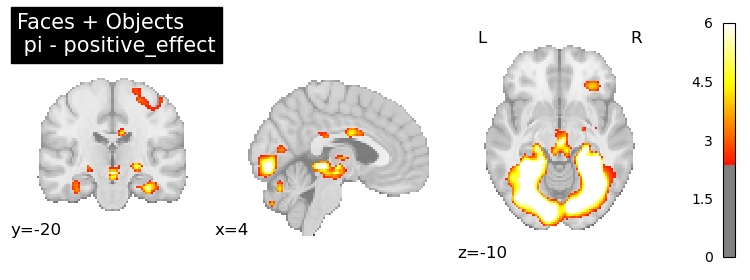

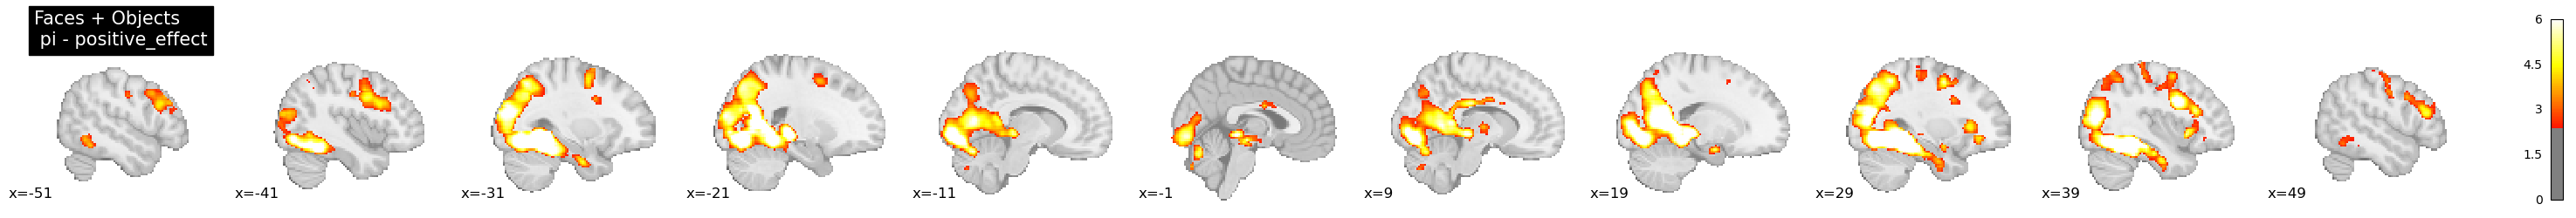

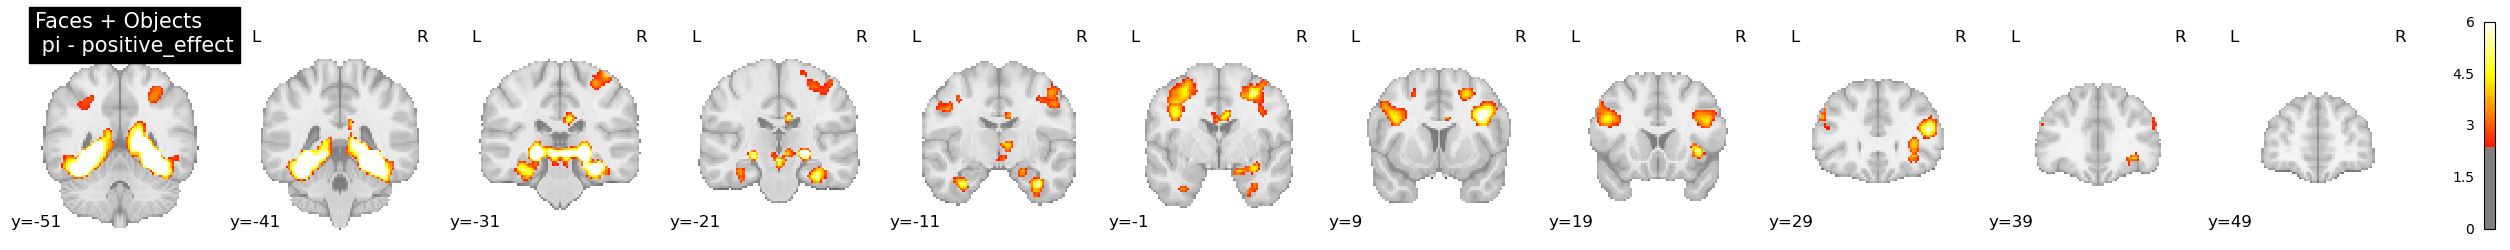

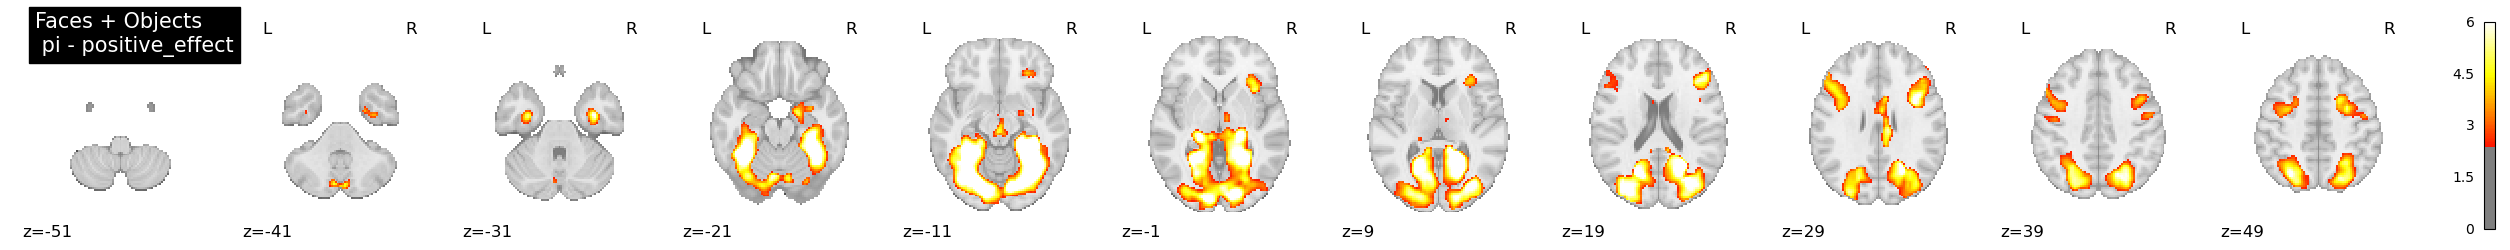

In [42]:
# then look at the pi youth
tstat_nii_pi = plot_whole_brain_results(group='pi',analysis_type='FaceObject',
                         contrast='zstat4',randomise_type='default',tstat_type='cluster_manual_tstat1')
